In [ ]:
# Importing functions and classes we'll use

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dropout, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from warnings import catch_warnings
from warnings import filterwarnings
from tqdm import tqdm
import keras
import sys
import scipy.stats
import json
import numpy.fft
import time
from decimal import Decimal
import math
import seaborn as sns
%matplotlib inline

In [ ]:
# fix random seed for reproducibility
tf.random.set_seed(1234)

In [ ]:
df = pd.read_excel('/content/sample_data/new_dataset.xlsx')
node1_delay = df[['node1_delay']]

dataset = node1_delay.values

# MA Filter Implementation

In [ ]:
# ASAP
class Metrics(object):
    def __init__(self, values):
        self.set_values( values )

    def set_values(self, values):
        self.values = values
        self.r = self.k = None

    @property
    def kurtosis(self):
        if self.k is None:
            self.k = scipy.stats.kurtosis(self.values)
        return self.k

    @property
    def roughness(self):
        if self.r is None:
            self.r = np.std(np.diff(self.values))
        return self.r

class ACF(Metrics):
    CORR_THRESH = 0.2
    def __init__(self, values, max_lag=None):
        super(ACF, self).__init__(values)
        if max_lag is None:
            max_lag = len(values) / 5
        self.max_lag = int(max_lag)
        self.max_acf = 0.0

        # Calculate autocorrelation via FFT
        # Demean
        demeaned = values - np.mean(values)
        # Pad data to power of 2
        l = int(2.0 ** (int(math.log(len(demeaned),2.0)) + 1))
        padded = np.append(demeaned, ([0.0] * (l - len(demeaned))))
        # FFT and inverse FFT
        F_f = numpy.fft.fft( padded )
        R_t = numpy.fft.ifft( F_f * np.conjugate(F_f) )
        self.correlations = R_t[:int(max_lag)].real / R_t[0].real

        # Find autocorrelation peaks
        self.peaks = []
        if len(self.correlations) >1 :
            positive = self.correlations[1] > self.correlations[0]
            max = 1
            for i in range(2, len(self.correlations)):
                if not positive and self.correlations[i] > self.correlations[i-1]:
                    max = i
                    positive = not positive
                elif positive and self.correlations[i] > self.correlations[max]:
                    max = i
                elif positive and self.correlations[i] < self.correlations[i-1]:
                    if max > 1 and self.correlations[max] > self.CORR_THRESH:
                        self.peaks.append(max)
                        if self.correlations[max] > self.max_acf:
                            self.max_acf = self.correlations[max]
                    positive = not positive
        # If there is no autocorrelation peak within the MAX_WINDOW boundary,
        # try windows from the largest to the smallest
        if len(self.peaks) <= 1:
            self.peaks = range(2, len(self.correlations))

def moving_average(data, _range):
    ret = np.cumsum(data)
    ret[_range:] = ret[int(_range):] - ret[:-int(_range)]
    return ret[int(_range) - 1:] / _range

def SMA(data, _range, slide):
    ret = moving_average(data, int(_range))[::int(slide)]
    return list(ret)

def binary_search(head,tail,data,min_obj,orig_kurt,window_size):
    while head <= tail:
        w = int(round((head + tail) / 2.0))
        smoothed = SMA(data,w,1)
        metrics  = Metrics(smoothed)
        if metrics.kurtosis >= orig_kurt:
            if metrics.roughness < min_obj:
                window_size = w
                min_obj = metrics.roughness
            head = w + 1
        else:
            tail = w - 1
    return window_size

def smooth_ASAP(data, max_window=5, resolution=None):
    data = np.array(data)
    # Preaggregate according to resolution
    slide_size = 1
    window_size = 1
    if resolution and len(data) >= 2 * resolution:
        slide_size = len(data) / resolution
        data = SMA(data, slide_size, slide_size)
    acf         = ACF(data, max_lag=len(data) / max_window)
    peaks       = acf.peaks
    orig_kurt   = acf.kurtosis
    min_obj     = acf.roughness
    lb          = 1
    largest_feasible = -1
    tail = len(data) / max_window
    for i in range(len(peaks) - 1, -1, -1):
        w = peaks[i]

        if w < lb or w == 1:
            break
        elif math.sqrt(1 - acf.correlations[w]) * window_size > math.sqrt(1 - acf.correlations[window_size]) * w:
            continue

        smoothed = SMA(data, w, 1)
        metrics = Metrics(smoothed)
        if metrics.roughness < min_obj and metrics.kurtosis >= orig_kurt:
            min_obj = metrics.roughness
            window_size = w
            lb = round( max(w*math.sqrt( (acf.max_acf -1) / (acf.correlations[w]-1) ), lb) )
    if largest_feasible > 0:
        if largest_feasible < len(peaks) - 2:
            tail = peaks[largest_feasible + 1]
        lb = max(lb, peaks[largest_feasible] + 1)

    window_size = binary_search(lb, tail, data, min_obj, orig_kurt, window_size)
    return window_size, slide_size

# Algorithm to transfer data in tabular format

In [ ]:
def create_multistep_dataset(data, n_input, n_out=1):
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end]
            X.append(x_input)
            y.append(data[in_end:out_end])
        # move along one time step
        in_start += 1
    return np.array(X), np.array(y)

# ESN Model Library

In [ ]:
def correct_dimensions(s, targetlength):
    """checks the dimensionality of some numeric argument s, broadcasts it
       to the specified length if possible.

    Args:
        s: None, scalar or 1D array
        targetlength: expected length of s

    Returns:
        None if s is None, else numpy vector of length targetlength
    """
    if s is not None:
        s = np.array(s)
        if s.ndim == 0:
            s = np.array([s] * targetlength)
        elif s.ndim == 1:
            if not len(s) == targetlength:
                raise ValueError("arg must have length " + str(targetlength))
        else:
            raise ValueError("Invalid argument")
    return s


def identity(x):
    return x


class ESN():

    def __init__(self, n_inputs, n_outputs, n_reservoir=200,
                 spectral_radius=0.95, sparsity=0, noise=0.001, input_shift=None,
                 input_scaling=None, teacher_forcing=True, feedback_scaling=None,
                 teacher_scaling=None, teacher_shift=None,
                 out_activation=identity, inverse_out_activation=identity,
                 random_state=None, silent=True):
        """
        Args:
            n_inputs: nr of input dimensions
            n_outputs: nr of output dimensions
            n_reservoir: nr of reservoir neurons
            spectral_radius: spectral radius of the recurrent weight matrix
            sparsity: proportion of recurrent weights set to zero
            noise: noise added to each neuron (regularization)
            input_shift: scalar or vector of length n_inputs to add to each
                        input dimension before feeding it to the network.
            input_scaling: scalar or vector of length n_inputs to multiply
                        with each input dimension before feeding it to the netw.
            teacher_forcing: if True, feed the target back into output units
            teacher_scaling: factor applied to the target signal
            teacher_shift: additive term applied to the target signal
            out_activation: output activation function (applied to the readout)
            inverse_out_activation: inverse of the output activation function
            random_state: positive integer seed, np.rand.RandomState object,
                          or None to use numpy's builting RandomState.
            silent: supress messages
        """
        # check for proper dimensionality of all arguments and write them down.
        self.n_inputs = n_inputs
        self.n_reservoir = n_reservoir
        self.n_outputs = n_outputs
        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.noise = noise
        self.input_shift = correct_dimensions(input_shift, n_inputs)
        self.input_scaling = correct_dimensions(input_scaling, n_inputs)

        self.teacher_scaling = teacher_scaling
        self.teacher_shift = teacher_shift

        self.out_activation = out_activation
        self.inverse_out_activation = inverse_out_activation
        self.random_state = random_state

        # the given random_state might be either an actual RandomState object,
        # a seed or None (in which case we use numpy's builtin RandomState)
        if isinstance(random_state, np.random.RandomState):
            self.random_state_ = random_state
        elif random_state:
            try:
                self.random_state_ = np.random.RandomState(random_state)
            except TypeError as e:
                raise Exception("Invalid seed: " + str(e))
        else:
            self.random_state_ = np.random.mtrand._rand

        self.teacher_forcing = teacher_forcing
        self.silent = silent
        self.initweights()

    def initweights(self):
        # initialize recurrent weights:
        # begin with a random matrix centered around zero:
        W = self.random_state_.rand(self.n_reservoir, self.n_reservoir) - 0.5
        # delete the fraction of connections given by (self.sparsity):
        W[self.random_state_.rand(*W.shape) < self.sparsity] = 0
        # compute the spectral radius of these weights:
        radius = np.max(np.abs(np.linalg.eigvals(W)))
        # rescale them to reach the requested spectral radius:
        self.W = W * (self.spectral_radius / radius)

        # random input weights:
        self.W_in = self.random_state_.rand(
            self.n_reservoir, self.n_inputs) * 2 - 1
        # random feedback (teacher forcing) weights:
        self.W_feedb = self.random_state_.rand(
            self.n_reservoir, self.n_outputs) * 2 - 1

    def _update(self, state, input_pattern, output_pattern):
        """performs one update step.

        i.e., computes the next network state by applying the recurrent weights
        to the last state & and feeding in the current input and output patterns
        """
        if self.teacher_forcing:
            preactivation = (np.dot(self.W, state)
                             + np.dot(self.W_in, input_pattern)
                             + np.dot(self.W_feedb, output_pattern))
        else:
            preactivation = (np.dot(self.W, state)
                             + np.dot(self.W_in, input_pattern))
        return (np.tanh(preactivation)
                + self.noise * (self.random_state_.rand(self.n_reservoir) - 0.5))

    def _scale_inputs(self, inputs):
        """for each input dimension j: multiplies by the j'th entry in the
        input_scaling argument, then adds the j'th entry of the input_shift
        argument."""
        if self.input_scaling is not None:
            inputs = np.dot(inputs, np.diag(self.input_scaling))
        if self.input_shift is not None:
            inputs = inputs + self.input_shift
        return inputs

    def _scale_teacher(self, teacher):
        """multiplies the teacher/target signal by the teacher_scaling argument,
        then adds the teacher_shift argument to it."""
        if self.teacher_scaling is not None:
            teacher = teacher * self.teacher_scaling
        if self.teacher_shift is not None:
            teacher = teacher + self.teacher_shift
        return teacher

    def _unscale_teacher(self, teacher_scaled):
        """inverse operation of the _scale_teacher method."""
        if self.teacher_shift is not None:
            teacher_scaled = teacher_scaled - self.teacher_shift
        if self.teacher_scaling is not None:
            teacher_scaled = teacher_scaled / self.teacher_scaling
        return teacher_scaled

    def fit(self, inputs, outputs, inspect=False):
        """
        Collect the network's reaction to training data, train readout weights.

        Args:
            inputs: array of dimensions (N_training_samples x n_inputs)
            outputs: array of dimension (N_training_samples x n_outputs)
            inspect: show a visualisation of the collected reservoir states

        Returns:
            the network's output on the training data, using the trained weights
        """
        # transform any vectors of shape (x,) into vectors of shape (x,1):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        if outputs.ndim < 2:
            outputs = np.reshape(outputs, (len(outputs), -1))
        # transform input and teacher signal:
        inputs_scaled = self._scale_inputs(inputs)
        teachers_scaled = self._scale_teacher(outputs)

        if not self.silent:
            print("harvesting states...")
        # step the reservoir through the given input,output pairs:
        states = np.zeros((inputs.shape[0], self.n_reservoir))
        for n in range(1, inputs.shape[0]):
            states[n, :] = self._update(states[n - 1], inputs_scaled[n, :],
                                        teachers_scaled[n - 1, :])

        # learn the weights, i.e. find the linear combination of collected
        # network states that is closest to the target output
        if not self.silent:
            print("fitting...")
        # we'll disregard the first few states:
        transient = min(int(inputs.shape[1] / 10), 100)
        # include the raw inputs:
        extended_states = np.hstack((states, inputs_scaled))
        # Solve for W_out:
        self.W_out = np.dot(np.linalg.pinv(extended_states[transient:, :]),
                            self.inverse_out_activation(teachers_scaled[transient:, :])).T

        # remember the last state for later:
        self.laststate = states[-1, :]
        self.lastinput = inputs[-1, :]
        self.lastoutput = teachers_scaled[-1, :]

        # optionally visualize the collected states
        if inspect:
            from matplotlib import pyplot as plt
            # (^-- we depend on matplotlib only if this option is used)
            plt.figure(
                figsize=(states.shape[0] * 0.0025, states.shape[1] * 0.01))
            plt.imshow(extended_states.T, aspect='auto',
                       interpolation='nearest')
            plt.colorbar()

        if not self.silent:
            print("training error:")
        # apply learned weights to the collected states:
        pred_train = self._unscale_teacher(self.out_activation(
            np.dot(extended_states, self.W_out.T)))
        if not self.silent:
            print(np.sqrt(np.mean((pred_train - outputs)**2)))
        return pred_train

    def predict(self, inputs, continuation=True):
        """
        Apply the learned weights to the network's reactions to new input.

        Args:
            inputs: array of dimensions (N_test_samples x n_inputs)
            continuation: if True, start the network from the last training state

        Returns:
            Array of output activations
        """
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        n_samples = inputs.shape[0]

        if continuation:
            laststate = self.laststate
            lastinput = self.lastinput
            lastoutput = self.lastoutput
        else:
            laststate = np.zeros(self.n_reservoir)
            lastinput = np.zeros(self.n_inputs)
            lastoutput = np.zeros(self.n_outputs)

        inputs = np.vstack([lastinput, self._scale_inputs(inputs)])
        states = np.vstack(
            [laststate, np.zeros((n_samples, self.n_reservoir))])
        outputs = np.vstack(
            [lastoutput, np.zeros((n_samples, self.n_outputs))])

        for n in range(n_samples):
            states[
                n + 1, :] = self._update(states[n, :], inputs[n + 1, :], outputs[n, :])
            outputs[n + 1, :] = self.out_activation(np.dot(self.W_out,
                                                           np.concatenate([states[n + 1, :], inputs[n + 1, :]])))

        return self._unscale_teacher(self.out_activation(outputs[1:]))

# Function to evaluate multi-step forecasting models

In [ ]:
from sklearn.metrics import mean_squared_error

def eval_model(Y_true, Y_pred):
    scores = []

    # Calculate scores for each value on the horizon
    # For each of the col in Y_true we have corresponding y_pred
    for i in range(Y_true.shape[1]):
        mse = mean_squared_error(Y_true[:, i], Y_pred[:, i])
        rmse = np.sqrt(mse)
        scores.append(rmse)

    # Calculate score for the whole prediction
    total_score = 0
    for row in range(Y_true.shape[0]):
        for col in range(Y_true.shape[1]):
            total_score += (Y_true[row, col] - Y_pred[row, col]) ** 2

    total_score = np.sqrt(total_score / (Y_true.shape[0] * Y_true.shape[1]))
    return total_score, scores

In [ ]:
def evaluate_multistep_forecast(predictions, actual):
    # Calculate RMSE and MAE for each prediction
    rmse = np.sqrt(mean_squared_error(actual, predictions))
    mae = mean_absolute_error(actual, predictions)

    return rmse, mae

# Recursive Strategy

In [ ]:
def recursive_strategy(model, X_row, n_steps):
    forecasts = []
    shape_0 = X_row.shape[0]
    shape_1 = X_row.shape[1]

    for i in range(n_steps):
        X_row = np.reshape(X_row, (shape_0, 1, shape_1))
        forecast = model.predict(X_row, verbose=0)
        X_row.reshape(X_row.shape[2],)
        forecasts.append(forecast[0, 0])
        X_row = X_row.tolist()
        X_row[0][0].append(forecast[0, 0])
        X_row = X_row[0][0][1:]
        X_row = np.array(X_row)
    return forecasts

def make_predictions(model, X, n_steps):
    predictions = []
    for i in tqdm(range(len(X)), desc="Progress"):
      row_forecasts = recursive_strategy(model, X[i, :], n_steps)
      predictions.append(row_forecasts)
    return predictions

## First Dataset : Node1 Delay

### Persistance Model

In [ ]:
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

for horizon in range(2, 21):
    print(f"=================== horizon = {horizon}======================")
    # reshape into X=t and Y=t+1
    trainX, trainY = create_multistep_dataset(train, 1, horizon)
    testX, testY = create_multistep_dataset(test, 1, horizon)

    # Record the starting time to generate predictions
    start_time = time.time()

    last_values = testX[:, -1]
    predictions = np.tile(last_values, (horizon, 1)).T

    # Record the ending time
    end_time = time.time()
    elapsed_time = end_time - start_time

    testRMSE = np.sqrt(mean_squared_error(testY, predictions))
    testMAE = mean_absolute_error(testY, predictions)

    print('Persistence Test RMSE : %.5f' % (testRMSE))
    print('Persistence Test MAE : %.5f' % (testMAE))
    print("Persistence Elapsed Time : %.5f" % (elapsed_time), "seconds")

Window Size:  10
17991 2000
=================== horizon = 2======================
Persistence Test RMSE : 0.02720
Persistence Test MAE : 0.02189
Persistence Elapsed Time : 0.00022 seconds
=================== horizon = 3======================
Persistence Test RMSE : 0.03144
Persistence Test MAE : 0.02507
Persistence Elapsed Time : 0.00014 seconds
=================== horizon = 4======================
Persistence Test RMSE : 0.03517
Persistence Test MAE : 0.02787
Persistence Elapsed Time : 0.00015 seconds
=================== horizon = 5======================
Persistence Test RMSE : 0.03849
Persistence Test MAE : 0.03028
Persistence Elapsed Time : 0.00016 seconds
=================== horizon = 6======================
Persistence Test RMSE : 0.04156
Persistence Test MAE : 0.03246
Persistence Elapsed Time : 0.00010 seconds
=================== horizon = 7======================
Persistence Test RMSE : 0.04448
Persistence Test MAE : 0.03456
Persistence Elapsed Time : 0.00012 seconds
============

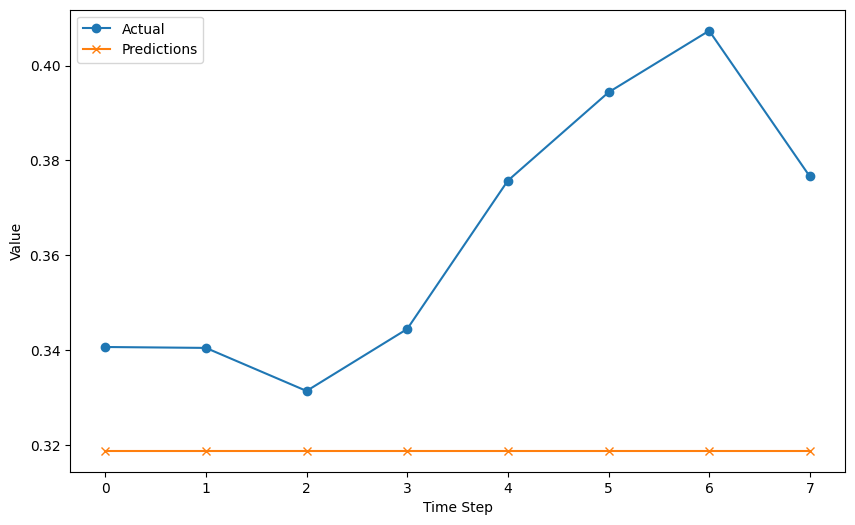

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(testY[0, :], label="Actual", marker='o')
plt.plot(predictions[0, :], label="Predictions", marker='x')
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.show()

### LSTM Model

In [ ]:
# Best Params
look_back = 300 #200
num_hidden_layers = 2
learning_rate = 0.0015250869829489782
batch_size = 44
epochs = 82
lstm_units_layer_0 = 15
lstm_units_layer_1 = 32


node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Crée et entraîne le modèle pour l'horizon de prévision i
model = Sequential()
model.add(LSTM(units=lstm_units_layer_0, return_sequences=True))
model.add(LSTM(units=lstm_units_layer_1))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(lr=learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Record the starting time to training the model
training_start_time = time.time()

model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time

print("LSTM Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

# horizons = [2, 4, 6, 8, 10]

horizons = [8, 10]

for horizon in horizons:
    print(f"=================== horizon = {horizon}======================")
    # Record the starting time to generate predictions
    predictions_start_time = time.time()

    testPredict = make_predictions(model, testX, horizon)

    # Record the ending time of generating predictions
    predictions_end_time = time.time()
    predictions_elapsed_time = predictions_end_time - predictions_start_time

    testPredict = np.array(testPredict)
    _, new_testY = create_multistep_dataset(test, look_back, horizon)

    testRMSE = np.sqrt(mean_squared_error(new_testY, testPredict[:len(new_testY), :]))
    testMAE = mean_absolute_error(new_testY, testPredict[:len(new_testY), :])

    print('LSTM Test RMSE : %.5f' % (testRMSE))
    print('LSTM Test MAE : %.5f' % (testMAE))
    print("LSTM Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000
Epoch 1/82


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


403/403 [==============================] - 9s 5ms/step - loss: 0.0030
Epoch 2/82
403/403 [==============================] - 2s 5ms/step - loss: 0.0020
Epoch 3/82
403/403 [==============================] - 2s 6ms/step - loss: 0.0011
Epoch 4/82
403/403 [==============================] - 3s 7ms/step - loss: 8.5798e-04
Epoch 5/82
403/403 [==============================] - 2s 5ms/step - loss: 7.2655e-04
Epoch 6/82
403/403 [==============================] - 2s 5ms/step - loss: 6.6444e-04
Epoch 7/82
403/403 [==============================] - 2s 5ms/step - loss: 5.9995e-04
Epoch 8/82
403/403 [==============================] - 2s 5ms/step - loss: 5.6067e-04
Epoch 9/82
403/403 [==============================] - 3s 7ms/step - loss: 5.5618e-04
Epoch 10/82
403/403 [==============================] - 2s 6ms/step - loss: 5.7556e-04
Epoch 11/82
403/403 [==============================] - 2s 5ms/step - loss: 5.4437e-04
Epoch 12/82
403/403 [==============================] - 2s 5ms/step - loss: 5.2543e-04


Progress: 100%|██████████| 1700/1700 [17:06<00:00,  1.66it/s]


LSTM Test RMSE : 0.04555
LSTM Test MAE : 0.03521
LSTM Elapsed Time To generate Predictions : 1026.11798 seconds
=================== horizon = 10======================


Progress: 100%|██████████| 1700/1700 [23:54<00:00,  1.18it/s]

LSTM Test RMSE : 0.05164
LSTM Test MAE : 0.03982
LSTM Elapsed Time To generate Predictions : 1434.72751 seconds


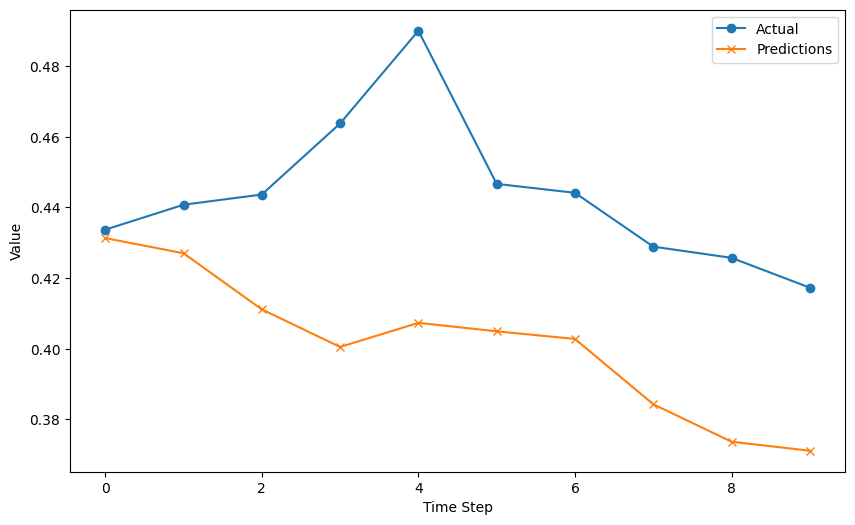

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(new_testY[1600, :], label="Actual", marker='o')
plt.plot(testPredict[1600, :], label="Predictions", marker='x')
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.show()

In [ ]:
testRMSE = np.sqrt(mean_squared_error(new_testY, testPredict[:len(new_testY), :]))

In [ ]:
testRMSE

0.02515008767748288

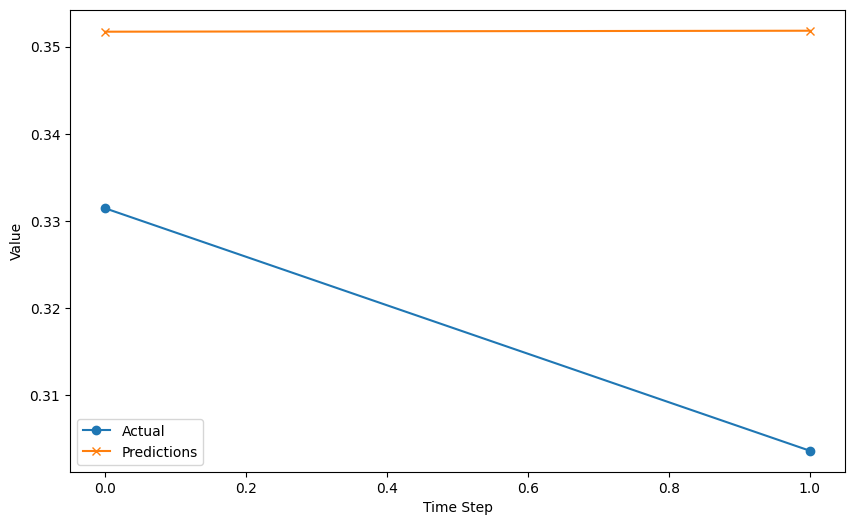

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(new_testY[0, :], label="Actual", marker='o')
plt.plot(testPredict[0, :], label="Predictions", marker='x')
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.show()

In [ ]:
# Best Params
look_back = 100
num_hidden_layers = 2
learning_rate = 0.0015250869829489782
batch_size = 44
epochs = 82
lstm_units_layer_0 = 15
lstm_units_layer_1 = 32


node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, 1)
testX, testY = create_multistep_dataset(test, look_back, 1)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)

# Crée et entraîne le modèle pour l'horizon de prévision i
model = Sequential()
model.add(LSTM(units=lstm_units_layer_0, return_sequences=True))
model.add(LSTM(units=lstm_units_layer_1))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(lr=learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Record the starting time to training the model
training_start_time = time.time()

model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1)

# Record the ending time of training the model
training_end_time = time.time()
training_elapsed_time = training_end_time - training_start_time


# Record the starting time to generate predictions
predictions_start_time = time.time()

testPredict = []
last_input = testX[-1]
for _ in range(5):  # Predict the next 5 steps
    next_pred = model.predict(last_input.reshape(1, n_input, 1))[0][0]
    testPredict.append(next_pred)
    last_input = np.roll(last_input, -1)
    last_input[-1] = next_pred


testPredict = model.predict(testX, verbose=0)

# Record the ending time of generating predictions
predictions_end_time = time.time()
predictions_elapsed_time = predictions_end_time - predictions_start_time

# calculate root mean squared error
LSTM_RMSE = np.sqrt(mean_squared_error(testY, testPredict))
LSTM_MAE = mean_absolute_error(testY, testPredict)

print("LSTM Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")
print("LSTM Model Generate predictions Elapsed Time : %.5f" % (predictions_elapsed_time), "seconds")
print('LSTM Test RMSE : %.5f' % (LSTM_RMSE))
print('LSTM Test MAE : %.5f' % (LSTM_MAE))

# Direct Strategy

In [ ]:
# Best Params
look_back = 300
num_hidden_layers = 2
learning_rate = 0.0015250869829489782
batch_size = 44
epochs = 82
num_units_layer_0 = 15
num_units_layer_1 = 32

# ESN Params
n_reservoir = 10
sparsity = 0.4
spectral_radius = 10.0
noise = 0.001
look_back = 342

In [ ]:
def direct_multistep_strategy(model, trainX, trainY):
    n = trainY.shape[1]  # Nombre de colonnes de Y (horizons de prévision)
    models = []  # Liste pour stocker les modèles entraînés

    if model == 'lstm' :
        total_training_elapsed_time = 0
        for i in tqdm(range(n)):

            y = trainY[:, i]  # Sélectionne la colonne i de Y
            # Crée et entraîne le modèle pour l'horizon de prévision i
            model = Sequential()
            model.add(LSTM(units=num_units_layer_0, return_sequences=True))
            model.add(LSTM(units=num_units_layer_1))
            model.add(Dense(1))
            optimizer = keras.optimizers.Adam(lr=learning_rate)
            model.compile(loss='mean_squared_error', optimizer=optimizer)

            # Record the starting time to training the model
            training_start_time = time.time()

            model.fit(trainX, y, epochs=epochs, batch_size=batch_size, verbose=0)

            # Record the ending time of training the model
            training_end_time = time.time()
            training_elapsed_time = training_end_time - training_start_time
            total_training_elapsed_time += training_elapsed_time
            models.append(model)  # Ajoute le modèle à la liste

            print("Model Done !")
        print("All Models Done !")

    elif model == 'gru' :
        total_training_elapsed_time = 0
        for i in tqdm(range(n)):
            y = trainY[:, i]  # Sélectionne la colonne i de Y

            # Crée et entraîne le modèle pour l'horizon de prévision i

            model = Sequential()
            model.add(GRU(units=num_units_layer_0, return_sequences=True))
            model.add(GRU(units=num_units_layer_1))
            model.add(Dense(1))
            optimizer = keras.optimizers.Adam(lr=learning_rate)
            model.compile(loss='mean_squared_error', optimizer=optimizer)

            # Record the starting time to training the model
            training_start_time = time.time()

            model.fit(trainX, y, epochs=epochs, batch_size=batch_size, verbose=0)

            # Record the ending time of training the model
            training_end_time = time.time()
            training_elapsed_time = training_end_time - training_start_time
            total_training_elapsed_time += training_elapsed_time
            models.append(model)  # Ajoute le modèle à la liste

            print("Model Done !")
        print("All Models Done !")
    elif model == 'rnn' :
        total_training_elapsed_time = 0
        for i in tqdm(range(n)):
            y = trainY[:, i]  # Sélectionne la colonne i de Y

            # Crée et entraîne le modèle pour l'horizon de prévision i

            model = Sequential()
            model.add(SimpleRNN(units=num_units_layer_0, return_sequences=True))
            model.add(SimpleRNN(units=num_units_layer_1))
            model.add(Dense(1))
            optimizer = keras.optimizers.Adam(lr=learning_rate)
            model.compile(loss='mean_squared_error', optimizer=optimizer)

            # Record the starting time to training the model
            training_start_time = time.time()

            model.fit(trainX, y, epochs=epochs, batch_size=batch_size, verbose=0)

            # Record the ending time of training the model
            training_end_time = time.time()
            training_elapsed_time = training_end_time - training_start_time
            total_training_elapsed_time += training_elapsed_time
            models.append(model)  # Ajoute le modèle à la liste

            print("Model Done !")
        print("All Models Done !")
    elif model == 'esn' :
        total_training_elapsed_time = 0
        for i in tqdm(range(n)):
            y = trainY[:, i]  # Sélectionne la colonne i de Y

            # Crée et entraîne le modèle pour l'horizon de prévision i

            model = ESN(n_inputs = look_back,
                n_outputs = 1,
                n_reservoir = n_reservoir,
                sparsity=sparsity,
                random_state=1234,
                spectral_radius=spectral_radius,
                noise = noise,
                silent = False,
                teacher_scaling = 10,
              )
            # Record the starting time to training the model
            training_start_time = time.time()

            pred_train = model.fit(trainX, y)

            # Record the ending time of training the model
            training_end_time = time.time()
            training_elapsed_time = training_end_time - training_start_time
            total_training_elapsed_time += training_elapsed_time
            models.append(model)  # Ajoute le modèle à la liste

            print("Model Done !")
        print("All Models Done !")
    return models, total_training_elapsed_time

In [ ]:
def predict_using_models(models, X, model='all'):
    n = len(models)  # Nombre de modèles

    # Initialisation d'une matrice pour stocker les prédictions
    predictions = np.zeros((X.shape[0], n))

    # Record the starting time to generate predictions
    predictions_start_time = time.time()

    if model == 'esn':
      for i, model in tqdm(enumerate(models)):
        # Effectue les prédictions pour le modèle i
        y_pred = model.predict(X)
        predictions[:, i] = np.squeeze(y_pred)
    else :

      for i, model in tqdm(enumerate(models)):
          # Effectue les prédictions pour le modèle i
          y_pred = model.predict(X, verbose=0)
          predictions[:, i] = np.squeeze(y_pred)

    # Record the ending time of generating predictions
    predictions_end_time = time.time()
    predictions_elapsed_time = predictions_end_time - predictions_start_time

    return predictions, predictions_elapsed_time

### LSTM Model

#### Horizon = 2

In [ ]:
horizon = 2
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = direct_multistep_strategy('lstm', trainX, trainY)

print("LSTM Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

# make predictions
testPredict, predictions_elapsed_time = predict_using_models(models, testX)

testRMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
testMAE = mean_absolute_error(testY, testPredict[:len(testY), :])

print('LSTM Test RMSE : %.5f' % (testRMSE))
print('LSTM Test MAE : %.5f' % (testMAE))
print("LSTM Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
 50%|█████     | 1/2 [03:26<03:26, 206.56s/it]

Model Done !


100%|██████████| 2/2 [06:08<00:00, 184.41s/it]


Model Done !
All Models Done !
LSTM Model Training Elapsed Time : 368.63541 seconds


2it [00:02,  1.06s/it]

LSTM Test RMSE : 0.02402
LSTM Test MAE : 0.01939
LSTM Elapsed Time To generate Predictions : 2.13098 seconds


#### Horizon = 4

In [ ]:
horizon = 4
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = direct_multistep_strategy('lstm', trainX, trainY)

print("LSTM Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

# make predictions
testPredict, predictions_elapsed_time = predict_using_models(models, testX)

testRMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
testMAE = mean_absolute_error(testY, testPredict[:len(testY), :])

print('LSTM Test RMSE : %.5f' % (testRMSE))
print('LSTM Test MAE : %.5f' % (testMAE))
print("LSTM Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
 25%|██▌       | 1/4 [02:38<07:55, 158.43s/it]

Model Done !


 50%|█████     | 2/4 [05:24<05:25, 162.93s/it]

Model Done !


 75%|███████▌  | 3/4 [08:07<02:43, 163.16s/it]

Model Done !


100%|██████████| 4/4 [10:47<00:00, 161.83s/it]


Model Done !
All Models Done !
LSTM Model Training Elapsed Time : 647.23179 seconds


4it [00:04,  1.08s/it]

LSTM Test RMSE : 0.02877
LSTM Test MAE : 0.02307
LSTM Elapsed Time To generate Predictions : 4.31572 seconds


#### Horizon = 6

In [ ]:
horizon = 6
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = direct_multistep_strategy('lstm', trainX, trainY)

print("LSTM Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

# make predictions
testPredict, predictions_elapsed_time = predict_using_models(models, testX)

testRMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
testMAE = mean_absolute_error(testY, testPredict[:len(testY), :])

print('LSTM Test RMSE : %.5f' % (testRMSE))
print('LSTM Test MAE : %.5f' % (testMAE))
print("LSTM Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
 17%|█▋        | 1/6 [03:27<17:17, 207.43s/it]

Model Done !


 33%|███▎      | 2/6 [06:13<12:13, 183.33s/it]

Model Done !


 50%|█████     | 3/6 [08:59<08:45, 175.07s/it]

Model Done !


 67%|██████▋   | 4/6 [12:24<06:14, 187.21s/it]

Model Done !


 83%|████████▎ | 5/6 [15:14<03:00, 180.87s/it]

Model Done !


100%|██████████| 6/6 [18:40<00:00, 186.72s/it]


Model Done !
All Models Done !
LSTM Model Training Elapsed Time : 1120.19067 seconds


6it [00:09,  1.61s/it]

LSTM Test RMSE : 0.03311
LSTM Test MAE : 0.02599
LSTM Elapsed Time To generate Predictions : 9.66910 seconds


#### Horizon = 8

In [ ]:
horizon = 8
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = direct_multistep_strategy('lstm', trainX, trainY)

print("LSTM Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

# make predictions
testPredict, predictions_elapsed_time = predict_using_models(models, testX)

testRMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
testMAE = mean_absolute_error(testY, testPredict[:len(testY), :])

print('LSTM Test RMSE : %.5f' % (testRMSE))
print('LSTM Test MAE : %.5f' % (testMAE))
print("LSTM Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
 12%|█▎        | 1/8 [02:54<20:24, 174.90s/it]

Model Done !


 25%|██▌       | 2/8 [06:20<19:18, 193.16s/it]

Model Done !


 38%|███▊      | 3/8 [09:27<15:50, 190.12s/it]

Model Done !


 50%|█████     | 4/8 [12:53<13:06, 196.58s/it]

Model Done !


 62%|██████▎   | 5/8 [15:33<09:09, 183.26s/it]

Model Done !


 75%|███████▌  | 6/8 [18:04<05:44, 172.25s/it]

Model Done !


 88%|████████▊ | 7/8 [20:44<02:48, 168.44s/it]

Model Done !


100%|██████████| 8/8 [23:37<00:00, 177.13s/it]


Model Done !
All Models Done !
LSTM Model Training Elapsed Time : 1416.86246 seconds


8it [00:09,  1.13s/it]

LSTM Test RMSE : 0.03642
LSTM Test MAE : 0.02830
LSTM Elapsed Time To generate Predictions : 9.09336 seconds


#### Horizon = 10

In [ ]:
horizon = 10
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = direct_multistep_strategy('lstm', trainX, trainY)

print("LSTM Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

# make predictions
testPredict, predictions_elapsed_time = predict_using_models(models, testX)

testRMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
testMAE = mean_absolute_error(testY, testPredict[:len(testY), :])

print('LSTM Test RMSE : %.5f' % (testRMSE))
print('LSTM Test MAE : %.5f' % (testMAE))
print("LSTM Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000


  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
 10%|█         | 1/10 [03:25<30:52, 205.80s/it]

Model Done !


 20%|██        | 2/10 [06:52<27:30, 206.30s/it]

Model Done !


 30%|███       | 3/10 [09:35<21:46, 186.67s/it]

Model Done !


 40%|████      | 4/10 [12:48<18:54, 189.14s/it]

Model Done !


 50%|█████     | 5/10 [15:46<15:25, 185.17s/it]

Model Done !


 60%|██████    | 6/10 [18:32<11:54, 178.53s/it]

Model Done !


 70%|███████   | 7/10 [21:15<08:40, 173.50s/it]

Model Done !


 80%|████████  | 8/10 [24:41<06:07, 183.78s/it]

Model Done !


 90%|█████████ | 9/10 [27:14<02:54, 174.30s/it]

Model Done !


100%|██████████| 10/10 [30:14<00:00, 181.45s/it]


Model Done !
All Models Done !
LSTM Model Training Elapsed Time : 1814.29116 seconds


10it [00:11,  1.10s/it]

LSTM Test RMSE : 0.04218
LSTM Test MAE : 0.03298
LSTM Elapsed Time To generate Predictions : 11.02615 seconds


### GRU Model

#### Horizon = 2

In [ ]:
horizon = 2
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = direct_multistep_strategy('gru', trainX, trainY)

print("GRU Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

# make predictions
testPredict, predictions_elapsed_time = predict_using_models(models, testX)

testRMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
testMAE = mean_absolute_error(testY, testPredict[:len(testY), :])

print('GRU Test RMSE : %.5f' % (testRMSE))
print('GRU Test MAE : %.5f' % (testMAE))
print("GRU Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
 50%|█████     | 1/2 [02:31<02:31, 151.55s/it]

Model Done !


100%|██████████| 2/2 [04:55<00:00, 147.61s/it]


Model Done !
All Models Done !
GRU Model Training Elapsed Time : 295.16508 seconds


2it [00:02,  1.42s/it]

GRU Test RMSE : 0.02470
GRU Test MAE : 0.02002
GRU Elapsed Time To generate Predictions : 2.84358 seconds


#### Horizon = 4

In [ ]:
horizon = 4
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = direct_multistep_strategy('gru', trainX, trainY)

print("GRU Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

# make predictions
testPredict, predictions_elapsed_time = predict_using_models(models, testX)

testRMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
testMAE = mean_absolute_error(testY, testPredict[:len(testY), :])

print('GRU Test RMSE : %.5f' % (testRMSE))
print('GRU Test MAE : %.5f' % (testMAE))
print("GRU Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
 25%|██▌       | 1/4 [02:26<07:20, 146.70s/it]

Model Done !


 50%|█████     | 2/4 [04:55<04:56, 148.22s/it]

Model Done !


 75%|███████▌  | 3/4 [08:09<02:48, 168.70s/it]

Model Done !


100%|██████████| 4/4 [11:13<00:00, 168.42s/it]


Model Done !
All Models Done !
GRU Model Training Elapsed Time : 673.59231 seconds


4it [00:03,  1.03it/s]

GRU Test RMSE : 0.02922
GRU Test MAE : 0.02353
GRU Elapsed Time To generate Predictions : 3.88605 seconds


#### Horizon = 6

In [ ]:
horizon = 6
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = direct_multistep_strategy('gru', trainX, trainY)

print("GRU Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

# make predictions
testPredict, predictions_elapsed_time = predict_using_models(models, testX)

testRMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
testMAE = mean_absolute_error(testY, testPredict[:len(testY), :])

print('GRU Test RMSE : %.5f' % (testRMSE))
print('GRU Test MAE : %.5f' % (testMAE))
print("GRU Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
 17%|█▋        | 1/6 [02:54<14:33, 174.76s/it]

Model Done !


 33%|███▎      | 2/6 [05:45<11:30, 172.66s/it]

Model Done !


 50%|█████     | 3/6 [08:28<08:24, 168.06s/it]

Model Done !


 67%|██████▋   | 4/6 [11:06<05:28, 164.22s/it]

Model Done !


 83%|████████▎ | 5/6 [14:10<02:51, 171.36s/it]

Model Done !


100%|██████████| 6/6 [16:59<00:00, 169.87s/it]


Model Done !
All Models Done !
GRU Model Training Elapsed Time : 1019.08502 seconds


6it [00:05,  1.05it/s]

GRU Test RMSE : 0.03387
GRU Test MAE : 0.02663
GRU Elapsed Time To generate Predictions : 5.72668 seconds


#### Horizon = 8

In [ ]:
horizon = 8
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = direct_multistep_strategy('gru', trainX, trainY)

print("GRU Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

# make predictions
testPredict, predictions_elapsed_time = predict_using_models(models, testX)

testRMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
testMAE = mean_absolute_error(testY, testPredict[:len(testY), :])

print('GRU Test RMSE : %.5f' % (testRMSE))
print('GRU Test MAE : %.5f' % (testMAE))
print("GRU Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
 12%|█▎        | 1/8 [03:26<24:04, 206.32s/it]

Model Done !


 25%|██▌       | 2/8 [06:04<17:49, 178.26s/it]

Model Done !


 38%|███▊      | 3/8 [09:04<14:55, 179.02s/it]

Model Done !


 50%|█████     | 4/8 [12:30<12:38, 189.56s/it]

Model Done !


 62%|██████▎   | 5/8 [15:57<09:47, 195.67s/it]

Model Done !


 75%|███████▌  | 6/8 [18:36<06:06, 183.34s/it]

Model Done !


 88%|████████▊ | 7/8 [21:10<02:53, 173.76s/it]

Model Done !


100%|██████████| 8/8 [24:36<00:00, 184.51s/it]


Model Done !
All Models Done !
GRU Model Training Elapsed Time : 1475.91159 seconds


8it [00:09,  1.19s/it]

GRU Test RMSE : 0.03666
GRU Test MAE : 0.02837
GRU Elapsed Time To generate Predictions : 9.50767 seconds


#### Horizon = 10

In [ ]:
horizon = 10
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = direct_multistep_strategy('gru', trainX, trainY)

print("GRU Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

# make predictions
testPredict, predictions_elapsed_time = predict_using_models(models, testX)

testRMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
testMAE = mean_absolute_error(testY, testPredict[:len(testY), :])

print('GRU Test RMSE : %.5f' % (testRMSE))
print('GRU Test MAE : %.5f' % (testMAE))
print("GRU Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000


  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
 10%|█         | 1/10 [02:28<22:16, 148.45s/it]

Model Done !


 20%|██        | 2/10 [05:01<20:07, 150.96s/it]

Model Done !


 30%|███       | 3/10 [07:38<17:55, 153.67s/it]

Model Done !


 40%|████      | 4/10 [10:21<15:46, 157.70s/it]

Model Done !


 50%|█████     | 5/10 [13:50<14:39, 175.88s/it]

Model Done !


 60%|██████    | 6/10 [16:51<11:51, 177.82s/it]

Model Done !


 70%|███████   | 7/10 [19:58<09:02, 180.71s/it]

Model Done !


 80%|████████  | 8/10 [23:24<06:17, 188.82s/it]

Model Done !


 90%|█████████ | 9/10 [26:17<03:03, 183.85s/it]

Model Done !


100%|██████████| 10/10 [29:43<00:00, 178.32s/it]


Model Done !
All Models Done !
GRU Model Training Elapsed Time : 1782.99367 seconds


10it [00:16,  1.68s/it]

GRU Test RMSE : 0.04268
GRU Test MAE : 0.03340
GRU Elapsed Time To generate Predictions : 16.84478 seconds


### RNN Model

#### Horizon = 2

In [ ]:
horizon = 2
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = direct_multistep_strategy('rnn', trainX, trainY)

print("RNN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

# make predictions
testPredict, predictions_elapsed_time = predict_using_models(models, testX)

testRMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
testMAE = mean_absolute_error(testY, testPredict[:len(testY), :])

print('RNN Test RMSE : %.5f' % (testRMSE))
print('RNN Test MAE : %.5f' % (testMAE))
print("RNN Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
 50%|█████     | 1/2 [02:24<02:24, 144.35s/it]

Model Done !


100%|██████████| 2/2 [04:27<00:00, 133.72s/it]


Model Done !
All Models Done !
RNN Model Training Elapsed Time : 267.39001 seconds


2it [00:00,  2.24it/s]

RNN Test RMSE : 0.02391
RNN Test MAE : 0.01937
RNN Elapsed Time To generate Predictions : 0.90377 seconds


#### Horizon = 4

In [ ]:
horizon = 4
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = direct_multistep_strategy('rnn', trainX, trainY)

print("RNN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

# make predictions
testPredict, predictions_elapsed_time = predict_using_models(models, testX)

testRMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
testMAE = mean_absolute_error(testY, testPredict[:len(testY), :])

print('RNN Test RMSE : %.5f' % (testRMSE))
print('RNN Test MAE : %.5f' % (testMAE))
print("RNN Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
 25%|██▌       | 1/4 [02:23<07:11, 143.91s/it]

Model Done !


 50%|█████     | 2/4 [04:09<04:02, 121.09s/it]

Model Done !


 75%|███████▌  | 3/4 [05:55<01:54, 114.52s/it]

Model Done !


100%|██████████| 4/4 [08:20<00:00, 125.00s/it]


Model Done !
All Models Done !
RNN Model Training Elapsed Time : 499.90637 seconds


4it [00:01,  2.09it/s]

RNN Test RMSE : 0.03112
RNN Test MAE : 0.02530
RNN Elapsed Time To generate Predictions : 1.92336 seconds


#### Horizon = 6

In [ ]:
horizon = 6
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = direct_multistep_strategy('rnn', trainX, trainY)

print("RNN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

# make predictions
testPredict, predictions_elapsed_time = predict_using_models(models, testX)

testRMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
testMAE = mean_absolute_error(testY, testPredict[:len(testY), :])

print('RNN Test RMSE : %.5f' % (testRMSE))
print('RNN Test MAE : %.5f' % (testMAE))
print("RNN Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
 17%|█▋        | 1/6 [01:52<09:21, 112.21s/it]

Model Done !


 33%|███▎      | 2/6 [04:15<08:43, 130.78s/it]

Model Done !


 50%|█████     | 3/6 [06:01<05:57, 119.28s/it]

Model Done !


 67%|██████▋   | 4/6 [07:47<03:47, 113.87s/it]

Model Done !


 83%|████████▎ | 5/6 [09:26<01:48, 108.70s/it]

Model Done !


100%|██████████| 6/6 [11:06<00:00, 111.00s/it]


Model Done !
All Models Done !
RNN Model Training Elapsed Time : 665.87608 seconds


6it [00:03,  1.77it/s]

RNN Test RMSE : 0.03439
RNN Test MAE : 0.02689
RNN Elapsed Time To generate Predictions : 3.40509 seconds


#### Horizon = 8

In [ ]:
horizon = 8
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = direct_multistep_strategy('rnn', trainX, trainY)

print("RNN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

# make predictions
testPredict, predictions_elapsed_time = predict_using_models(models, testX)

testRMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
testMAE = mean_absolute_error(testY, testPredict[:len(testY), :])

print('RNN Test RMSE : %.5f' % (testRMSE))
print('RNN Test MAE : %.5f' % (testMAE))
print("RNN Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
 12%|█▎        | 1/8 [01:34<11:01, 94.50s/it]

Model Done !


 25%|██▌       | 2/8 [03:32<10:49, 108.20s/it]

Model Done !


 38%|███▊      | 3/8 [05:19<08:58, 107.70s/it]

Model Done !


 50%|█████     | 4/8 [07:05<07:08, 107.15s/it]

Model Done !


 62%|██████▎   | 5/8 [09:30<06:01, 120.59s/it]

Model Done !


 75%|███████▌  | 6/8 [11:22<03:55, 117.92s/it]

Model Done !


 88%|████████▊ | 7/8 [13:13<01:55, 115.63s/it]

Model Done !


100%|██████████| 8/8 [15:37<00:00, 117.20s/it]


Model Done !
All Models Done !
RNN Model Training Elapsed Time : 937.42033 seconds


8it [00:03,  2.03it/s]

RNN Test RMSE : 0.03728
RNN Test MAE : 0.02886
RNN Elapsed Time To generate Predictions : 3.94438 seconds


#### Horizon = 10

In [ ]:
horizon = 10
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = direct_multistep_strategy('rnn', trainX, trainY)

print("RNN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

# make predictions
testPredict, predictions_elapsed_time = predict_using_models(models, testX)

testRMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
testMAE = mean_absolute_error(testY, testPredict[:len(testY), :])

print('RNN Test RMSE : %.5f' % (testRMSE))
print('RNN Test MAE : %.5f' % (testMAE))
print("RNN Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000


  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
 10%|█         | 1/10 [02:23<21:34, 143.82s/it]

Model Done !


 20%|██        | 2/10 [04:48<19:14, 144.31s/it]

Model Done !


 30%|███       | 3/10 [07:12<16:48, 144.04s/it]

Model Done !


 40%|████      | 4/10 [09:03<13:05, 130.98s/it]

Model Done !


 50%|█████     | 5/10 [10:48<10:08, 121.75s/it]

Model Done !


 60%|██████    | 6/10 [13:12<08:36, 129.23s/it]

Model Done !


 70%|███████   | 7/10 [14:58<06:05, 121.72s/it]

Model Done !


 80%|████████  | 8/10 [17:25<04:19, 129.73s/it]

Model Done !


 90%|█████████ | 9/10 [19:13<02:03, 123.10s/it]

Model Done !


100%|██████████| 10/10 [21:02<00:00, 126.27s/it]


Model Done !
All Models Done !
RNN Model Training Elapsed Time : 1262.44483 seconds


10it [00:05,  1.86it/s]

RNN Test RMSE : 0.04208
RNN Test MAE : 0.03251
RNN Elapsed Time To generate Predictions : 5.39870 seconds


### ESN Model

#### Horizon = 2

In [ ]:
horizon = 2
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

models, training_elapsed_time = direct_multistep_strategy('esn', trainX, trainY)

print("ESN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

# make predictions
testPredict, predictions_elapsed_time = predict_using_models(models, testX, 'esn')

testRMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
testMAE = mean_absolute_error(testY, testPredict[:len(testY), :])

print('ESN Test RMSE : %.5f' % (testRMSE))
print('ESN Test MAE : %.5f' % (testMAE))
print("ESN Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000


  0%|          | 0/2 [00:00<?, ?it/s]

harvesting states...
fitting...


 50%|█████     | 1/2 [00:04<00:04,  4.40s/it]

training error:
0.015270793751639037
Model Done !
harvesting states...
fitting...


100%|██████████| 2/2 [00:07<00:00,  3.93s/it]


training error:
0.02162305578014343
Model Done !
All Models Done !
ESN Model Training Elapsed Time : 7.85470 seconds


2it [00:00, 10.15it/s]

ESN Test RMSE : 0.01941
ESN Test MAE : 0.01598
ESN Elapsed Time To generate Predictions : 0.21909 seconds


#### Horizon = 4

In [ ]:
horizon = 4
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

models, training_elapsed_time = direct_multistep_strategy('esn', trainX, trainY)

print("ESN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

# make predictions
testPredict, predictions_elapsed_time = predict_using_models(models, testX, 'esn')

testRMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
testMAE = mean_absolute_error(testY, testPredict[:len(testY), :])

print('ESN Test RMSE : %.5f' % (testRMSE))
print('ESN Test MAE : %.5f' % (testMAE))
print("ESN Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000


  0%|          | 0/4 [00:00<?, ?it/s]

harvesting states...
fitting...


 25%|██▌       | 1/4 [00:01<00:05,  1.74s/it]

training error:
0.015270359257787766
Model Done !
harvesting states...
fitting...


 50%|█████     | 2/4 [00:03<00:03,  1.82s/it]

training error:
0.021623391595436012
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 3/4 [00:05<00:01,  1.77s/it]

training error:
0.026512655964592752
Model Done !
harvesting states...
fitting...


100%|██████████| 4/4 [00:07<00:00,  1.79s/it]


training error:
0.030720816382164836
Model Done !
All Models Done !
ESN Model Training Elapsed Time : 7.15839 seconds


4it [00:00, 19.03it/s]

ESN Test RMSE : 0.02517
ESN Test MAE : 0.01999
ESN Elapsed Time To generate Predictions : 0.22987 seconds


#### Horizon = 6

In [ ]:
horizon = 6
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

models, training_elapsed_time = direct_multistep_strategy('esn', trainX, trainY)

print("ESN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

# make predictions
testPredict, predictions_elapsed_time = predict_using_models(models, testX, 'esn')

testRMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
testMAE = mean_absolute_error(testY, testPredict[:len(testY), :])

print('ESN Test RMSE : %.5f' % (testRMSE))
print('ESN Test MAE : %.5f' % (testMAE))
print("ESN Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000


  0%|          | 0/6 [00:00<?, ?it/s]

harvesting states...
fitting...


 17%|█▋        | 1/6 [00:01<00:08,  1.72s/it]

training error:
0.015271201339669914
Model Done !
harvesting states...
fitting...


 33%|███▎      | 2/6 [00:04<00:09,  2.38s/it]

training error:
0.02162457812524003
Model Done !
harvesting states...
fitting...


 50%|█████     | 3/6 [00:06<00:06,  2.24s/it]

training error:
0.026513648198884125
Model Done !
harvesting states...
fitting...


 67%|██████▋   | 4/6 [00:08<00:04,  2.08s/it]

training error:
0.030721967488939683
Model Done !
harvesting states...
fitting...


 83%|████████▎ | 5/6 [00:10<00:01,  1.96s/it]

training error:
0.03433442847032744
Model Done !
harvesting states...
fitting...


100%|██████████| 6/6 [00:11<00:00,  1.99s/it]


training error:
0.03737361843667793
Model Done !
All Models Done !
ESN Model Training Elapsed Time : 11.94157 seconds


6it [00:00, 22.11it/s]

ESN Test RMSE : 0.02990
ESN Test MAE : 0.02332
ESN Elapsed Time To generate Predictions : 0.28549 seconds


#### Horizon = 8

In [ ]:
horizon = 8
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

models, training_elapsed_time = direct_multistep_strategy('esn', trainX, trainY)

print("ESN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

# make predictions
testPredict, predictions_elapsed_time = predict_using_models(models, testX, 'esn')

testRMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
testMAE = mean_absolute_error(testY, testPredict[:len(testY), :])

print('ESN Test RMSE : %.5f' % (testRMSE))
print('ESN Test MAE : %.5f' % (testMAE))
print("ESN Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000


  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:01<00:12,  1.75s/it]

training error:
0.015271161021982914
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:03<00:11,  1.99s/it]

training error:
0.021624497690553655
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:06<00:12,  2.40s/it]

training error:
0.026514093145313205
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:08<00:08,  2.17s/it]

training error:
0.03072301782173809
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:10<00:06,  2.00s/it]

training error:
0.034334742603897565
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:12<00:03,  1.92s/it]

training error:
0.03737334312921099
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [00:13<00:01,  1.86s/it]

training error:
0.04043248989843529
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [00:15<00:00,  1.94s/it]


training error:
0.04299240305505189
Model Done !
All Models Done !
ESN Model Training Elapsed Time : 15.50191 seconds


8it [00:00, 22.34it/s]

ESN Test RMSE : 0.03416
ESN Test MAE : 0.02636
ESN Elapsed Time To generate Predictions : 0.37918 seconds


#### Horizon = 10

In [ ]:
horizon = 10
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

models, training_elapsed_time = direct_multistep_strategy('esn', trainX, trainY)

print("ESN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

# make predictions
testPredict, predictions_elapsed_time = predict_using_models(models, testX, 'esn')

testRMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
testMAE = mean_absolute_error(testY, testPredict[:len(testY), :])

print('ESN Test RMSE : %.5f' % (testRMSE))
print('ESN Test MAE : %.5f' % (testMAE))
print("ESN Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000


  0%|          | 0/10 [00:00<?, ?it/s]

harvesting states...
fitting...


 10%|█         | 1/10 [00:02<00:22,  2.56s/it]

training error:
0.015269984644152287
Model Done !
harvesting states...
fitting...


 20%|██        | 2/10 [00:05<00:20,  2.53s/it]

training error:
0.021622764106365558
Model Done !
harvesting states...
fitting...


 30%|███       | 3/10 [00:06<00:15,  2.16s/it]

training error:
0.02651076797746923
Model Done !
harvesting states...
fitting...


 40%|████      | 4/10 [00:08<00:11,  1.98s/it]

training error:
0.030720022554978473
Model Done !
harvesting states...
fitting...


 50%|█████     | 5/10 [00:10<00:09,  1.89s/it]

training error:
0.03433293521294907
Model Done !
harvesting states...
fitting...


 60%|██████    | 6/10 [00:12<00:07,  1.86s/it]

training error:
0.037371249492040896
Model Done !
harvesting states...
fitting...


 70%|███████   | 7/10 [00:13<00:05,  1.82s/it]

training error:
0.040428805788041366
Model Done !
harvesting states...
fitting...


 80%|████████  | 8/10 [00:16<00:04,  2.01s/it]

training error:
0.04298909065200008
Model Done !
harvesting states...
fitting...


 90%|█████████ | 9/10 [00:18<00:02,  2.23s/it]

training error:
0.045278797543759686
Model Done !
harvesting states...
fitting...


100%|██████████| 10/10 [00:20<00:00,  2.06s/it]


training error:
0.0478570184199416
Model Done !
All Models Done !
ESN Model Training Elapsed Time : 20.58492 seconds


10it [00:00, 21.42it/s]

ESN Test RMSE : 0.03834
ESN Test MAE : 0.02939
ESN Elapsed Time To generate Predictions : 0.48014 seconds


# DirRec Strategy

In [ ]:
def dirRec_strategy(models, X_row, n_steps, model = 'all'):
    forecasts = []
    if model == 'esn':
      for i in range(n_steps):
          forecast = models[i].predict(np.array([X_row]))
          forecasts.append(forecast[0, 0])
          X_row = X_row.tolist()
          X_row.append(forecast[0, 0])
          X_row = X_row[1:]
          X_row = np.array(X_row)
    else :
      shape_0 = X_row.shape[0]
      shape_1 = X_row.shape[1]

      for i in range(n_steps):
          X_row = np.reshape(X_row, (shape_0, 1, shape_1))
          forecast = models[i].predict(X_row, verbose=0)
          X_row.reshape(X_row.shape[2],)
          forecasts.append(forecast[0, 0])
          X_row = X_row.tolist()
          X_row[0][0].append(forecast[0, 0])
          X_row = X_row[0][0][1:]
          X_row = np.array(X_row)
    return forecasts

In [ ]:
# Best Params
look_back = 300
num_hidden_layers = 2
learning_rate = 6.95812073050639e-05 # 0.0015250869829489782
batch_size = 30 #44
epochs = 42#82
num_units_layer_0 = 15
num_units_layer_1 = 32

# ESN Params
n_reservoir = 851
sparsity = 0.2
spectral_radius = 10.0
noise = 0.007
look_back = 11

In [ ]:
def direct_multistep_strategy(model, trainX, trainY):
    n = trainY.shape[1]  # Nombre de colonnes de Y (horizons de prévision)
    models = []  # Liste pour stocker les modèles entraînés

    if model == 'lstm' :
        total_training_elapsed_time = 0
        for i in tqdm(range(n)):

            y = trainY[:, i]  # Sélectionne la colonne i de Y
            # Crée et entraîne le modèle pour l'horizon de prévision i
            model = Sequential()
            model.add(LSTM(units=num_units_layer_0, return_sequences=True))
            model.add(LSTM(units=num_units_layer_1))
            model.add(Dense(1))
            optimizer = keras.optimizers.Adam(lr=learning_rate)
            model.compile(loss='mean_squared_error', optimizer=optimizer)

            # Record the starting time to training the model
            training_start_time = time.time()

            model.fit(trainX, y, epochs=epochs, batch_size=batch_size, verbose=0)

            # Record the ending time of training the model
            training_end_time = time.time()
            training_elapsed_time = training_end_time - training_start_time
            total_training_elapsed_time += training_elapsed_time
            models.append(model)  # Ajoute le modèle à la liste

            print("Model Done !")
        print("All Models Done !")

    elif model == 'gru' :
        total_training_elapsed_time = 0
        for i in tqdm(range(n)):
            y = trainY[:, i]  # Sélectionne la colonne i de Y

            # Crée et entraîne le modèle pour l'horizon de prévision i

            model = Sequential()
            model.add(GRU(units=num_units_layer_0, return_sequences=True))
            model.add(GRU(units=num_units_layer_1))
            model.add(Dense(1))
            optimizer = keras.optimizers.Adam(lr=learning_rate)
            model.compile(loss='mean_squared_error', optimizer=optimizer)

            # Record the starting time to training the model
            training_start_time = time.time()

            model.fit(trainX, y, epochs=epochs, batch_size=batch_size, verbose=0)

            # Record the ending time of training the model
            training_end_time = time.time()
            training_elapsed_time = training_end_time - training_start_time
            total_training_elapsed_time += training_elapsed_time
            models.append(model)  # Ajoute le modèle à la liste

            print("Model Done !")
        print("All Models Done !")
    elif model == 'rnn' :
        total_training_elapsed_time = 0
        for i in tqdm(range(n)):
            y = trainY[:, i]  # Sélectionne la colonne i de Y

            # Crée et entraîne le modèle pour l'horizon de prévision i

            model = Sequential()
            model.add(SimpleRNN(units=num_units_layer_0, return_sequences=True))
            model.add(SimpleRNN(units=num_units_layer_1))
            model.add(Dense(1))
            optimizer = keras.optimizers.Adam(lr=learning_rate)
            model.compile(loss='mean_squared_error', optimizer=optimizer)

            # Record the starting time to training the model
            training_start_time = time.time()

            model.fit(trainX, y, epochs=epochs, batch_size=batch_size, verbose=0)

            # Record the ending time of training the model
            training_end_time = time.time()
            training_elapsed_time = training_end_time - training_start_time
            total_training_elapsed_time += training_elapsed_time
            models.append(model)  # Ajoute le modèle à la liste

            print("Model Done !")
        print("All Models Done !")
    elif model == 'esn' :
        total_training_elapsed_time = 0
        for i in tqdm(range(n)):
            y = trainY[:, i]  # Sélectionne la colonne i de Y

            # Crée et entraîne le modèle pour l'horizon de prévision i

            model = ESN(n_inputs = look_back,
                n_outputs = 1,
                n_reservoir = n_reservoir,
                sparsity=sparsity,
                random_state=1234,
                spectral_radius=spectral_radius,
                noise = noise,
                silent = False,
                teacher_scaling = 10,
              )
            # Record the starting time to training the model
            training_start_time = time.time()

            pred_train = model.fit(trainX, y)

            # Record the ending time of training the model
            training_end_time = time.time()
            training_elapsed_time = training_end_time - training_start_time
            total_training_elapsed_time += training_elapsed_time
            models.append(model)  # Ajoute le modèle à la liste

            print("Model Done !")
        print("All Models Done !")
    return models, total_training_elapsed_time

In [ ]:
from tqdm import tqdm

def make_predictions(models, X, n_steps, model='all'):
    predictions = []
    # Record the starting time to generate predictions
    predictions_start_time = time.time()

    for i in tqdm(range(len(X)), desc="Progress"):
      if model == 'esn':
          row_forecasts = dirRec_strategy(models, X[i, :], n_steps, model)
      else :
          row_forecasts = dirRec_strategy(models, X[i, :], n_steps)
      predictions.append(row_forecasts)

    # Record the ending time of generating predictions
    predictions_end_time = time.time()
    predictions_elapsed_time = predictions_end_time - predictions_start_time
    return predictions, predictions_elapsed_time

### LSTM Model

#### Horizon = 2

In [ ]:
horizon = 2
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = direct_multistep_strategy('lstm', trainX, trainY)

print("LSTM Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

# make predictions
testPredict, predictions_elapsed_time = make_predictions(models, testX, horizon)
testPredict = np.array(testPredict)

testRMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
testMAE = mean_absolute_error(testY, testPredict[:len(testY), :])

print('LSTM Test RMSE : %.5f' % (testRMSE))
print('LSTM Test MAE : %.5f' % (testMAE))
print("LSTM Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
 50%|█████     | 1/2 [01:45<01:45, 105.25s/it]

Model Done !


100%|██████████| 2/2 [03:27<00:00, 103.69s/it]


Model Done !
All Models Done !
LSTM Model Training Elapsed Time : 206.18854 seconds


Progress: 100%|██████████| 1657/1657 [02:55<00:00,  9.45it/s]


LSTM Test RMSE : 0.02656
LSTM Test MAE : 0.02130
LSTM Elapsed Time To generate Predictions : 175.27250 seconds


#### Horizon = 4

In [ ]:
horizon = 4
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = direct_multistep_strategy('lstm', trainX, trainY)

print("LSTM Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

# make predictions
testPredict, predictions_elapsed_time = make_predictions(models, testX, horizon)
testPredict = np.array(testPredict)

testRMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
testMAE = mean_absolute_error(testY, testPredict[:len(testY), :])

print('LSTM Test RMSE : %.5f' % (testRMSE))
print('LSTM Test MAE : %.5f' % (testMAE))
print("LSTM Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
 25%|██▌       | 1/4 [01:43<05:10, 103.39s/it]

Model Done !


 50%|█████     | 2/4 [03:26<03:27, 103.50s/it]

Model Done !


 75%|███████▌  | 3/4 [05:10<01:43, 103.43s/it]

Model Done !


100%|██████████| 4/4 [06:54<00:00, 103.61s/it]


Model Done !
All Models Done !
LSTM Model Training Elapsed Time : 414.36245 seconds


Progress: 100%|██████████| 1655/1655 [05:48<00:00,  4.74it/s]


LSTM Test RMSE : 0.03889
LSTM Test MAE : 0.03007
LSTM Elapsed Time To generate Predictions : 348.90263 seconds


#### Horizon = 6

In [ ]:
horizon = 6
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = direct_multistep_strategy('lstm', trainX, trainY)

print("LSTM Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

# make predictions
testPredict, predictions_elapsed_time = make_predictions(models, testX, horizon)
testPredict = np.array(testPredict)

testRMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
testMAE = mean_absolute_error(testY, testPredict[:len(testY), :])

print('LSTM Test RMSE : %.5f' % (testRMSE))
print('LSTM Test MAE : %.5f' % (testMAE))
print("LSTM Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
 17%|█▋        | 1/6 [02:24<12:04, 144.96s/it]

Model Done !


 33%|███▎      | 2/6 [04:08<08:01, 120.31s/it]

Model Done !


 50%|█████     | 3/6 [05:50<05:36, 112.33s/it]

Model Done !


 67%|██████▋   | 4/6 [07:33<03:37, 108.68s/it]

Model Done !


 83%|████████▎ | 5/6 [09:15<01:46, 106.12s/it]

Model Done !


100%|██████████| 6/6 [10:59<00:00, 109.87s/it]


Model Done !
All Models Done !
LSTM Model Training Elapsed Time : 659.11179 seconds


Progress: 100%|██████████| 1653/1653 [08:39<00:00,  3.18it/s]

LSTM Test RMSE : 0.04754
LSTM Test MAE : 0.03594
LSTM Elapsed Time To generate Predictions : 519.82216 seconds


#### Horizon = 8

In [ ]:
horizon = 8
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = direct_multistep_strategy('lstm', trainX, trainY)

print("LSTM Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

# make predictions
testPredict, predictions_elapsed_time = make_predictions(models, testX, horizon)
testPredict = np.array(testPredict)

testRMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
testMAE = mean_absolute_error(testY, testPredict[:len(testY), :])

print('LSTM Test RMSE : %.5f' % (testRMSE))
print('LSTM Test MAE : %.5f' % (testMAE))
print("LSTM Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
 12%|█▎        | 1/8 [02:24<16:53, 144.83s/it]

Model Done !


 25%|██▌       | 2/8 [04:09<12:06, 121.06s/it]

Model Done !


 38%|███▊      | 3/8 [05:51<09:23, 112.69s/it]

Model Done !


 50%|█████     | 4/8 [08:17<08:21, 125.48s/it]

Model Done !


 62%|██████▎   | 5/8 [10:42<06:38, 132.68s/it]

Model Done !


 75%|███████▌  | 6/8 [12:25<04:05, 122.74s/it]

Model Done !


 88%|████████▊ | 7/8 [14:08<01:55, 115.99s/it]

Model Done !


100%|██████████| 8/8 [15:51<00:00, 118.96s/it]


Model Done !
All Models Done !
LSTM Model Training Elapsed Time : 951.53622 seconds


Progress: 100%|██████████| 1651/1651 [11:27<00:00,  2.40it/s]

LSTM Test RMSE : 0.04990
LSTM Test MAE : 0.03825
LSTM Elapsed Time To generate Predictions : 687.61924 seconds


#### Horizon = 10

In [ ]:
horizon = 10
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = direct_multistep_strategy('lstm', trainX, trainY)

print("LSTM Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

# make predictions
testPredict, predictions_elapsed_time = make_predictions(models, testX, horizon)
testPredict = np.array(testPredict)

testRMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
testMAE = mean_absolute_error(testY, testPredict[:len(testY), :])

print('LSTM Test RMSE : %.5f' % (testRMSE))
print('LSTM Test MAE : %.5f' % (testMAE))
print("LSTM Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000


  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
 10%|█         | 1/10 [01:32<13:50, 92.28s/it]

Model Done !


 20%|██        | 2/10 [02:54<11:33, 86.64s/it]

Model Done !


 30%|███       | 3/10 [04:17<09:53, 84.82s/it]

Model Done !


 40%|████      | 4/10 [05:42<08:30, 85.03s/it]

Model Done !


 50%|█████     | 5/10 [07:07<07:03, 84.72s/it]

Model Done !


 60%|██████    | 6/10 [08:33<05:40, 85.18s/it]

Model Done !


 70%|███████   | 7/10 [09:57<04:14, 84.74s/it]

Model Done !


 80%|████████  | 8/10 [11:22<02:49, 84.84s/it]

Model Done !


 90%|█████████ | 9/10 [12:46<01:24, 84.79s/it]

Model Done !


100%|██████████| 10/10 [14:13<00:00, 85.36s/it]


Model Done !
All Models Done !
LSTM Model Training Elapsed Time : 850.00934 seconds


Progress: 100%|██████████| 1649/1649 [14:27<00:00,  1.90it/s]

LSTM Test RMSE : 0.04917
LSTM Test MAE : 0.03805
LSTM Elapsed Time To generate Predictions : 867.37263 seconds


### GRU Model

#### Horizon = 2

In [ ]:
horizon = 2
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = direct_multistep_strategy('gru', trainX, trainY)

print("GRU Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

# make predictions
testPredict, predictions_elapsed_time = make_predictions(models, testX, horizon)
testPredict = np.array(testPredict)

testRMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
testMAE = mean_absolute_error(testY, testPredict[:len(testY), :])

print('GRU Test RMSE : %.5f' % (testRMSE))
print('GRU Test MAE : %.5f' % (testMAE))
print("GRU Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
 50%|█████     | 1/2 [01:16<01:16, 76.61s/it]

Model Done !


100%|██████████| 2/2 [02:15<00:00, 67.90s/it]


Model Done !
All Models Done !
GRU Model Training Elapsed Time : 135.69060 seconds


Progress: 100%|██████████| 1657/1657 [02:28<00:00, 11.16it/s]

GRU Test RMSE : 0.02616
GRU Test MAE : 0.02088
GRU Elapsed Time To generate Predictions : 148.45168 seconds


#### Horizon = 4

In [ ]:
horizon = 4
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = direct_multistep_strategy('gru', trainX, trainY)

print("GRU Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

# make predictions
testPredict, predictions_elapsed_time = make_predictions(models, testX, horizon)
testPredict = np.array(testPredict)

testRMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
testMAE = mean_absolute_error(testY, testPredict[:len(testY), :])

print('GRU Test RMSE : %.5f' % (testRMSE))
print('GRU Test MAE : %.5f' % (testMAE))
print("GRU Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
 25%|██▌       | 1/4 [01:04<03:12, 64.13s/it]

Model Done !


 50%|█████     | 2/4 [02:03<02:02, 61.34s/it]

Model Done !


 75%|███████▌  | 3/4 [03:02<01:00, 60.34s/it]

Model Done !


100%|██████████| 4/4 [04:02<00:00, 60.63s/it]


Model Done !
All Models Done !
GRU Model Training Elapsed Time : 242.47814 seconds


Progress: 100%|██████████| 1655/1655 [04:53<00:00,  5.64it/s]

GRU Test RMSE : 0.04017
GRU Test MAE : 0.03124
GRU Elapsed Time To generate Predictions : 293.68978 seconds


#### Horizon = 6

In [ ]:
horizon = 6
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = direct_multistep_strategy('gru', trainX, trainY)

print("GRU Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

# make predictions
testPredict, predictions_elapsed_time = make_predictions(models, testX, horizon)
testPredict = np.array(testPredict)

testRMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
testMAE = mean_absolute_error(testY, testPredict[:len(testY), :])

print('GRU Test RMSE : %.5f' % (testRMSE))
print('GRU Test MAE : %.5f' % (testMAE))
print("GRU Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
 17%|█▋        | 1/6 [00:58<04:54, 58.97s/it]

Model Done !


 33%|███▎      | 2/6 [02:23<04:56, 74.09s/it]

Model Done !


 50%|█████     | 3/6 [03:22<03:21, 67.16s/it]

Model Done !


 67%|██████▋   | 4/6 [04:21<02:07, 63.99s/it]

Model Done !


 83%|████████▎ | 5/6 [05:45<01:11, 71.30s/it]

Model Done !


100%|██████████| 6/6 [06:44<00:00, 67.49s/it]


Model Done !
All Models Done !
GRU Model Training Elapsed Time : 404.83786 seconds


Progress: 100%|██████████| 1653/1653 [07:19<00:00,  3.76it/s]

GRU Test RMSE : 0.04768
GRU Test MAE : 0.03589
GRU Elapsed Time To generate Predictions : 439.70439 seconds


#### Horizon = 8

In [ ]:
horizon = 8
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = direct_multistep_strategy('gru', trainX, trainY)

print("GRU Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

# make predictions
testPredict, predictions_elapsed_time = make_predictions(models, testX, horizon)
testPredict = np.array(testPredict)

testRMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
testMAE = mean_absolute_error(testY, testPredict[:len(testY), :])

print('GRU Test RMSE : %.5f' % (testRMSE))
print('GRU Test MAE : %.5f' % (testMAE))
print("GRU Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
 12%|█▎        | 1/8 [01:01<07:10, 61.43s/it]

Model Done !


 25%|██▌       | 2/8 [02:01<06:04, 60.82s/it]

Model Done !


 38%|███▊      | 3/8 [03:02<05:02, 60.53s/it]

Model Done !


 50%|█████     | 4/8 [04:02<04:02, 60.54s/it]

Model Done !


 62%|██████▎   | 5/8 [05:02<03:00, 60.17s/it]

Model Done !


 75%|███████▌  | 6/8 [06:02<02:00, 60.25s/it]

Model Done !


 88%|████████▊ | 7/8 [07:04<01:00, 60.74s/it]

Model Done !


100%|██████████| 8/8 [08:02<00:00, 60.32s/it]


Model Done !
All Models Done !
GRU Model Training Elapsed Time : 482.45730 seconds


Progress: 100%|██████████| 1651/1651 [09:34<00:00,  2.87it/s]

GRU Test RMSE : 0.05138
GRU Test MAE : 0.03935
GRU Elapsed Time To generate Predictions : 574.95247 seconds


#### Horizon = 10

In [ ]:
horizon = 10
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = direct_multistep_strategy('gru', trainX, trainY)

print("GRU Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

# make predictions
testPredict, predictions_elapsed_time = make_predictions(models, testX, horizon)
testPredict = np.array(testPredict)

testRMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
testMAE = mean_absolute_error(testY, testPredict[:len(testY), :])

print('GRU Test RMSE : %.5f' % (testRMSE))
print('GRU Test MAE : %.5f' % (testMAE))
print("GRU Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000


  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
 10%|█         | 1/10 [01:25<12:47, 85.33s/it]

Model Done !


 20%|██        | 2/10 [02:35<10:09, 76.15s/it]

Model Done !


 30%|███       | 3/10 [03:42<08:26, 72.30s/it]

Model Done !


 40%|████      | 4/10 [05:07<07:42, 77.14s/it]

Model Done !


 50%|█████     | 5/10 [06:14<06:08, 73.65s/it]

Model Done !


 60%|██████    | 6/10 [07:40<05:10, 77.66s/it]

Model Done !


 70%|███████   | 7/10 [08:47<03:42, 74.21s/it]

Model Done !


 80%|████████  | 8/10 [09:55<02:24, 72.13s/it]

Model Done !


 90%|█████████ | 9/10 [11:02<01:10, 70.61s/it]

Model Done !


100%|██████████| 10/10 [12:10<00:00, 73.07s/it]


Model Done !
All Models Done !
GRU Model Training Elapsed Time : 730.35837 seconds


Progress: 100%|██████████| 1649/1649 [16:01<00:00,  1.72it/s]

GRU Test RMSE : 0.04985
GRU Test MAE : 0.03846
GRU Elapsed Time To generate Predictions : 961.26955 seconds


### RNN Model

#### Horizon = 2

In [ ]:
horizon = 2
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = direct_multistep_strategy('rnn', trainX, trainY)

print("RNN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

# make predictions
testPredict, predictions_elapsed_time = make_predictions(models, testX, horizon)
testPredict = np.array(testPredict)

testRMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
testMAE = mean_absolute_error(testY, testPredict[:len(testY), :])

print('RNN Test RMSE : %.5f' % (testRMSE))
print('RNN Test MAE : %.5f' % (testMAE))
print("RNN Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
 50%|█████     | 1/2 [01:27<01:27, 87.80s/it]

Model Done !


100%|██████████| 2/2 [02:26<00:00, 73.23s/it]


Model Done !
All Models Done !
RNN Model Training Elapsed Time : 146.39439 seconds


Progress: 100%|██████████| 1657/1657 [03:27<00:00,  7.98it/s]

RNN Test RMSE : 0.02709
RNN Test MAE : 0.02152
RNN Elapsed Time To generate Predictions : 207.59370 seconds


#### Horizon = 4

In [ ]:
horizon = 4
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = direct_multistep_strategy('rnn', trainX, trainY)

print("RNN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

# make predictions
testPredict, predictions_elapsed_time = make_predictions(models, testX, horizon)
testPredict = np.array(testPredict)

testRMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
testMAE = mean_absolute_error(testY, testPredict[:len(testY), :])

print('RNN Test RMSE : %.5f' % (testRMSE))
print('RNN Test MAE : %.5f' % (testMAE))
print("RNN Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
 25%|██▌       | 1/4 [00:54<02:42, 54.02s/it]

Model Done !


 50%|█████     | 2/4 [02:17<02:22, 71.48s/it]

Model Done !


 75%|███████▌  | 3/4 [03:10<01:03, 63.12s/it]

Model Done !


100%|██████████| 4/4 [04:05<00:00, 61.39s/it]


Model Done !
All Models Done !
RNN Model Training Elapsed Time : 245.49753 seconds


Progress: 100%|██████████| 1655/1655 [06:35<00:00,  4.18it/s]

RNN Test RMSE : 0.04250
RNN Test MAE : 0.03321
RNN Elapsed Time To generate Predictions : 395.66879 seconds


#### Horizon = 6

In [ ]:
horizon = 6
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = direct_multistep_strategy('rnn', trainX, trainY)

print("RNN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

# make predictions
testPredict, predictions_elapsed_time = make_predictions(models, testX, horizon)
testPredict = np.array(testPredict)

testRMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
testMAE = mean_absolute_error(testY, testPredict[:len(testY), :])

print('RNN Test RMSE : %.5f' % (testRMSE))
print('RNN Test MAE : %.5f' % (testMAE))
print("RNN Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
 17%|█▋        | 1/6 [01:23<06:57, 83.45s/it]

Model Done !


 33%|███▎      | 2/6 [02:16<04:22, 65.58s/it]

Model Done !


 50%|█████     | 3/6 [03:09<02:59, 59.89s/it]

Model Done !


 67%|██████▋   | 4/6 [04:33<02:18, 69.43s/it]

Model Done !


 83%|████████▎ | 5/6 [05:27<01:03, 63.62s/it]

Model Done !


100%|██████████| 6/6 [06:50<00:00, 68.41s/it]


Model Done !
All Models Done !
RNN Model Training Elapsed Time : 410.33898 seconds


Progress: 100%|██████████| 1653/1653 [09:36<00:00,  2.87it/s]

RNN Test RMSE : 0.05210
RNN Test MAE : 0.03914
RNN Elapsed Time To generate Predictions : 576.38508 seconds


#### Horizon = 8

In [ ]:
horizon = 8
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = direct_multistep_strategy('rnn', trainX, trainY)

print("RNN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

# make predictions
testPredict, predictions_elapsed_time = make_predictions(models, testX, horizon)
testPredict = np.array(testPredict)

testRMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
testMAE = mean_absolute_error(testY, testPredict[:len(testY), :])

print('RNN Test RMSE : %.5f' % (testRMSE))
print('RNN Test MAE : %.5f' % (testMAE))
print("RNN Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
 12%|█▎        | 1/8 [01:24<09:48, 84.04s/it]

Model Done !


 25%|██▌       | 2/8 [02:23<06:57, 69.57s/it]

Model Done !


 38%|███▊      | 3/8 [03:47<06:19, 75.98s/it]

Model Done !


 50%|█████     | 4/8 [04:45<04:36, 69.16s/it]

Model Done !


 62%|██████▎   | 5/8 [06:09<03:43, 74.37s/it]

Model Done !


 75%|███████▌  | 6/8 [07:32<02:34, 77.49s/it]

Model Done !


 88%|████████▊ | 7/8 [08:33<01:11, 71.93s/it]

Model Done !


100%|██████████| 8/8 [09:57<00:00, 74.64s/it]


Model Done !
All Models Done !
RNN Model Training Elapsed Time : 596.79121 seconds


Progress: 100%|██████████| 1651/1651 [16:02<00:00,  1.71it/s]

RNN Test RMSE : 0.05342
RNN Test MAE : 0.04076
RNN Elapsed Time To generate Predictions : 962.99536 seconds


#### Horizon = 10

In [ ]:
horizon = 10
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = direct_multistep_strategy('rnn', trainX, trainY)

print("RNN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

# make predictions
testPredict, predictions_elapsed_time = make_predictions(models, testX, horizon)
testPredict = np.array(testPredict)

testRMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
testMAE = mean_absolute_error(testY, testPredict[:len(testY), :])

print('RNN Test RMSE : %.5f' % (testRMSE))
print('RNN Test MAE : %.5f' % (testMAE))
print("RNN Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000


  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
 10%|█         | 1/10 [01:23<12:31, 83.48s/it]

Model Done !


 20%|██        | 2/10 [02:18<08:53, 66.68s/it]

Model Done !


 30%|███       | 3/10 [03:14<07:13, 61.99s/it]

Model Done !


 40%|████      | 4/10 [04:38<07:03, 70.50s/it]

Model Done !


 50%|█████     | 5/10 [06:01<06:15, 75.16s/it]

Model Done !


 60%|██████    | 6/10 [07:25<05:11, 77.97s/it]

Model Done !


 70%|███████   | 7/10 [08:20<03:31, 70.61s/it]

Model Done !


 80%|████████  | 8/10 [09:44<02:29, 74.87s/it]

Model Done !


 90%|█████████ | 9/10 [11:08<01:17, 77.53s/it]

Model Done !


100%|██████████| 10/10 [12:31<00:00, 75.15s/it]


Model Done !
All Models Done !
RNN Model Training Elapsed Time : 751.24523 seconds


Progress: 100%|██████████| 1649/1649 [19:55<00:00,  1.38it/s]

RNN Test RMSE : 0.04991
RNN Test MAE : 0.03855
RNN Elapsed Time To generate Predictions : 1195.94007 seconds


### ESN Model

In [ ]:
def direct_multistep_strategy_op_params(trainX, trainY, look_back, n_reservoir, sparsity, spectral_radius, noise):
    n = trainY.shape[1]  # Nombre de colonnes de Y (horizons de prévision)
    models = []  # Liste pour stocker les modèles entraînés

    total_training_elapsed_time = 0
    for i in tqdm(range(n)):
        y = trainY[:, i]  # Sélectionne la colonne i de Y

        # Crée et entraîne le modèle pour l'horizon de prévision i

        model = ESN(n_inputs = look_back,
            n_outputs = 1,
            n_reservoir = n_reservoir,
            sparsity=sparsity,
            random_state=1234,
            spectral_radius=spectral_radius,
            noise = noise,
            silent = False,
            teacher_scaling = 10,
          )
        # Record the starting time to training the model
        training_start_time = time.time()

        pred_train = model.fit(trainX, y)

        # Record the ending time of training the model
        training_end_time = time.time()
        training_elapsed_time = training_end_time - training_start_time
        total_training_elapsed_time += training_elapsed_time
        models.append(model)  # Ajoute le modèle à la liste

        print("Model Done !")
    return models, total_training_elapsed_time

In [ ]:
!pip install -q optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 5.8 MB/s eta 0:00:00


In [ ]:
import optuna
from optuna.samplers import TPESampler

In [ ]:
horizon = 8
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]
valid_size = int(len(train) * 0.1)
temp_train = train[:-valid_size]
valid = train[-valid_size:]
print(len(train), len(temp_train), len(valid), len(test))

# Define the objective function for Optuna optimization
def objective(trial):
    # Sample hyperparameters to search

    n_reservoir = trial.suggest_int('n_reservoir', 10, 1000)   # -
    sparsity = trial.suggest_categorical('sparsity', [0.01, 0.1, 0.2, 0.3, 0.4, 0.5])   # -
    spectral_radius = trial.suggest_categorical('spectral_radius', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.25, 10.0])   # - spectral radius of W
    noise = trial.suggest_categorical('noise', [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009])       # - Noise Set
    look_back = trial.suggest_int('look_back', 10, 500)

    # reshape into X=t and Y=t+1
    trainX, trainY = create_multistep_dataset(temp_train, look_back, horizon)
    validX, validY = create_multistep_dataset(valid, look_back, horizon)

    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))
    validX = np.reshape(validX, (validX.shape[0], validX.shape[1]))

    models, training_elapsed_time = direct_multistep_strategy_op_params(trainX, trainY, look_back, n_reservoir, sparsity, spectral_radius, noise)

    # make predictions
    testPredict, predictions_elapsed_time = make_predictions(models, validX, horizon, model='esn')
    testPredict = np.array(testPredict)

    testRMSE = np.sqrt(mean_squared_error(validY, testPredict[:len(validY), :]))

    return testRMSE


# Create the Optuna study
study = optuna.create_study(direction='minimize')

# Record the starting time to generate predictions
start_time = time.time()

# Run the optimization
study.optimize(objective, n_trials=100)

# Record the ending time
end_time = time.time()
elapsed_time = end_time - start_time

print('done')
print("ESN HyperParameters Tuning Elapsed Time : %.5f" % (elapsed_time), "seconds")

# Print the best parameters and corresponding loss
best_params = study.best_params
best_loss = study.best_value
print("Best Parameters: ", best_params)
print("Best Loss: ", best_loss)

[I 2023-09-04 07:49:32,967] A new study created in memory with name: no-name-3ff1f0bd-8b59-4633-bd99-9a05a02201eb


Window Size:  10
17991 16192 1799 2000


  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:08<00:56,  8.05s/it]

training error:
0.015153987911823312
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:16<00:50,  8.41s/it]

training error:
0.015286036915949269
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:25<00:42,  8.49s/it]

training error:
0.015298635839185108
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:33<00:33,  8.31s/it]

training error:
0.015266669680780354
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:42<00:25,  8.44s/it]

training error:
0.015223724674582453
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:51<00:17,  8.65s/it]

training error:
0.015235629752916353
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [00:58<00:08,  8.20s/it]

training error:
0.015229761032122842
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:02<00:00,  7.86s/it]


training error:
0.015242222560295905
Model Done !


Progress: 100%|██████████| 1515/1515 [00:04<00:00, 323.82it/s]
[I 2023-09-04 07:50:40,645] Trial 0 finished with value: 0.07922002962525516 and parameters: {'n_reservoir': 375, 'sparsity': 0.2, 'spectral_radius': 0.1, 'noise': 0.005, 'look_back': 277}. Best is trial 0 with value: 0.07922002962525516.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:03<00:24,  3.45s/it]

training error:
0.01506185249893684
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:07<00:21,  3.55s/it]

training error:
0.015716744038112112
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:11<00:20,  4.04s/it]

training error:
0.01575651207265238
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:15<00:15,  3.79s/it]

training error:
0.015793501719624473
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:18<00:10,  3.65s/it]

training error:
0.01580910881376788
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:22<00:07,  3.81s/it]

training error:
0.015812285092559376
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [00:26<00:03,  3.99s/it]

training error:
0.015816162927452106
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [00:30<00:00,  3.80s/it]


training error:
0.01581900786827713
Model Done !


Progress: 100%|██████████| 1340/1340 [00:02<00:00, 497.47it/s]
[I 2023-09-04 07:51:13,886] Trial 1 finished with value: 0.07917065243947749 and parameters: {'n_reservoir': 201, 'sparsity': 0.1, 'spectral_radius': 0.7, 'noise': 0.001, 'look_back': 452}. Best is trial 1 with value: 0.07917065243947749.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:08<00:56,  8.03s/it]

training error:
0.015183610032309242
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:14<00:41,  6.96s/it]

training error:
0.021196643383397096
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:21<00:36,  7.32s/it]

training error:
0.02533837187660512
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:29<00:29,  7.33s/it]

training error:
0.028306469231475558
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:36<00:21,  7.18s/it]

training error:
0.03090856326946386
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:43<00:14,  7.27s/it]

training error:
0.03289950342629826
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [00:49<00:06,  6.95s/it]

training error:
0.03437997891900575
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [00:57<00:00,  7.23s/it]


training error:
0.03548100013569158
Model Done !


Progress: 100%|██████████| 1594/1594 [00:04<00:00, 355.20it/s]
[I 2023-09-04 07:52:16,390] Trial 2 finished with value: 0.05901372581437277 and parameters: {'n_reservoir': 561, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.003, 'look_back': 198}. Best is trial 2 with value: 0.05901372581437277.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:01<00:10,  1.55s/it]

training error:
0.015734138866019015
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:03<00:09,  1.50s/it]

training error:
0.015837169966607292
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:04<00:07,  1.50s/it]

training error:
0.015834094261676628
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:07<00:08,  2.04s/it]

training error:
0.01585454028295788
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:09<00:05,  1.89s/it]

training error:
0.015872445538070008
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:10<00:03,  1.73s/it]

training error:
0.01585851386034731
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [00:11<00:01,  1.64s/it]

training error:
0.015879225748913033
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [00:13<00:00,  1.67s/it]


training error:
0.015895626219291324
Model Done !


Progress: 100%|██████████| 1699/1699 [00:01<00:00, 895.17it/s]
[I 2023-09-04 07:52:31,717] Trial 3 finished with value: 0.07076985084800348 and parameters: {'n_reservoir': 200, 'sparsity': 0.4, 'spectral_radius': 1.1, 'noise': 0.004, 'look_back': 93}. Best is trial 2 with value: 0.05901372581437277.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:01<00:12,  1.83s/it]

training error:
0.015274994848613313
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:04<00:12,  2.13s/it]

training error:
0.015618504328010985
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:06<00:11,  2.28s/it]

training error:
0.015649055248632388
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:08<00:08,  2.14s/it]

training error:
0.015694299059344254
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:10<00:05,  1.98s/it]

training error:
0.015713993282156297
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:11<00:03,  1.89s/it]

training error:
0.015696475071924874
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [00:13<00:01,  1.84s/it]

training error:
0.015694578436022632
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [00:15<00:00,  1.93s/it]


training error:
0.015720620371418602
Model Done !


Progress: 100%|██████████| 1533/1533 [00:03<00:00, 433.52it/s]
[I 2023-09-04 07:52:50,771] Trial 4 finished with value: 0.07729383679657247 and parameters: {'n_reservoir': 143, 'sparsity': 0.01, 'spectral_radius': 0.9, 'noise': 0.008, 'look_back': 259}. Best is trial 2 with value: 0.05901372581437277.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:06<00:46,  6.61s/it]

training error:
0.015098148686235045
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:14<00:44,  7.42s/it]

training error:
0.015170666617464175
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:21<00:35,  7.14s/it]

training error:
0.015168930769482353
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:29<00:29,  7.42s/it]

training error:
0.015214082436520759
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:35<00:21,  7.10s/it]

training error:
0.015240207525152089
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:43<00:14,  7.38s/it]

training error:
0.015206704122728369
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [00:51<00:07,  7.56s/it]

training error:
0.0152025467307922
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [00:58<00:00,  7.30s/it]


training error:
0.015163782844106587
Model Done !


Progress: 100%|██████████| 1538/1538 [00:04<00:00, 319.97it/s]
[I 2023-09-04 07:53:54,160] Trial 5 finished with value: 0.07969297978476082 and parameters: {'n_reservoir': 540, 'sparsity': 0.2, 'spectral_radius': 0.7, 'noise': 0.004, 'look_back': 254}. Best is trial 2 with value: 0.05901372581437277.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:04<00:33,  4.84s/it]

training error:
0.01532334526606418
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:08<00:24,  4.12s/it]

training error:
0.015386294775134902
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:12<00:19,  3.89s/it]

training error:
0.015392308789478124
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:17<00:17,  4.40s/it]

training error:
0.015385376560887277
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:20<00:12,  4.14s/it]

training error:
0.015380699957629265
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:24<00:07,  3.95s/it]

training error:
0.01532877141148764
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [00:29<00:04,  4.33s/it]

training error:
0.015392036435281642
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [00:33<00:00,  4.17s/it]


training error:
0.015388910082487554
Model Done !


Progress: 100%|██████████| 1625/1625 [00:03<00:00, 520.18it/s]
[I 2023-09-04 07:54:30,777] Trial 6 finished with value: 0.0766770375173216 and parameters: {'n_reservoir': 390, 'sparsity': 0.5, 'spectral_radius': 0.6, 'noise': 0.007, 'look_back': 167}. Best is trial 2 with value: 0.05901372581437277.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:06<00:45,  6.57s/it]

training error:
0.015377463444035554
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:12<00:35,  5.96s/it]

training error:
0.015373956195748805
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:18<00:31,  6.20s/it]

training error:
0.015382322667513023
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:24<00:23,  5.92s/it]

training error:
0.015376342072043636
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:30<00:18,  6.09s/it]

training error:
0.015369234432926744
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:36<00:11,  5.97s/it]

training error:
0.015395346396971703
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [00:42<00:06,  6.08s/it]

training error:
0.01539832448438936
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [00:48<00:00,  6.07s/it]


training error:
0.015432710900573311
Model Done !


Progress: 100%|██████████| 1662/1662 [00:03<00:00, 416.86it/s]
[I 2023-09-04 07:55:23,478] Trial 7 finished with value: 0.07325304490936234 and parameters: {'n_reservoir': 535, 'sparsity': 0.3, 'spectral_radius': 1.1, 'noise': 0.004, 'look_back': 130}. Best is trial 2 with value: 0.05901372581437277.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:17<02:00, 17.15s/it]

training error:
0.01467887979461686
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:33<01:40, 16.77s/it]

training error:
0.014876980168221952
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:49<01:22, 16.52s/it]

training error:
0.01485381154653779
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [01:05<01:05, 16.32s/it]

training error:
0.014869927387198984
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [01:22<00:49, 16.53s/it]

training error:
0.014890268131332705
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:39<00:33, 16.53s/it]

training error:
0.014844675069614713
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:55<00:16, 16.48s/it]

training error:
0.014907321867948568
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [02:11<00:00, 16.44s/it]


training error:
0.01493598783865641
Model Done !


Progress: 100%|██████████| 1319/1319 [00:10<00:00, 126.76it/s]
[I 2023-09-04 07:57:45,598] Trial 8 finished with value: 0.07594164059340175 and parameters: {'n_reservoir': 851, 'sparsity': 0.1, 'spectral_radius': 1.25, 'noise': 0.007, 'look_back': 473}. Best is trial 2 with value: 0.05901372581437277.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:07<00:55,  7.90s/it]

training error:
0.014985286164722124
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:14<00:41,  6.87s/it]

training error:
0.015227815023359188
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:21<00:35,  7.09s/it]

training error:
0.015191767742625446
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:27<00:27,  6.80s/it]

training error:
0.015223597426133358
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:35<00:21,  7.21s/it]

training error:
0.015214424864387286
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:41<00:13,  6.88s/it]

training error:
0.015210284070260593
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [00:49<00:07,  7.12s/it]

training error:
0.015213101506726416
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [00:55<00:00,  6.99s/it]


training error:
0.015210181752488726
Model Done !


Progress: 100%|██████████| 1432/1432 [00:06<00:00, 229.68it/s]
[I 2023-09-04 07:58:47,884] Trial 9 finished with value: 0.07399080318504117 and parameters: {'n_reservoir': 479, 'sparsity': 0.4, 'spectral_radius': 1, 'noise': 0.008, 'look_back': 360}. Best is trial 2 with value: 0.05901372581437277.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:09<01:05,  9.32s/it]

training error:
0.020826053833276747
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:19<00:57,  9.59s/it]

training error:
0.026203960159778977
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:29<00:49,  9.84s/it]

training error:
0.030081843681373628
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:39<00:39,  9.90s/it]

training error:
0.032578913560368
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:49<00:29,  9.98s/it]

training error:
0.034454111936483005
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:58<00:19,  9.64s/it]

training error:
0.03571875206863479
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:09<00:09,  9.98s/it]

training error:
0.03650363830551441
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:19<00:00,  9.91s/it]


training error:
0.037803526188134956
Model Done !


Progress: 100%|██████████| 1782/1782 [00:06<00:00, 258.99it/s]
[I 2023-09-04 08:00:14,225] Trial 10 finished with value: 0.05580855752680299 and parameters: {'n_reservoir': 844, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.003, 'look_back': 10}. Best is trial 10 with value: 0.05580855752680299.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:10<01:16, 10.96s/it]

training error:
0.018052248238730147
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:22<01:06, 11.08s/it]

training error:
0.02463670099577567
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:33<00:55, 11.03s/it]

training error:
0.028769033570274403
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:44<00:43, 11.00s/it]

training error:
0.03131541470671395
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:54<00:32, 10.72s/it]

training error:
0.03313296795667799
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:04<00:21, 10.57s/it]

training error:
0.03478145929502986
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:15<00:10, 10.67s/it]

training error:
0.034207507357878995
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:26<00:00, 10.77s/it]


training error:
0.03522460534320624
Model Done !


Progress: 100%|██████████| 1777/1777 [00:08<00:00, 211.95it/s]
[I 2023-09-04 08:01:49,015] Trial 11 finished with value: 0.06235640624836696 and parameters: {'n_reservoir': 867, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.003, 'look_back': 15}. Best is trial 10 with value: 0.05580855752680299.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:07<00:54,  7.75s/it]

training error:
0.01647832833403132
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:16<00:48,  8.16s/it]

training error:
0.02282245068730218
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:24<00:40,  8.00s/it]

training error:
0.026889036400597602
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:33<00:33,  8.43s/it]

training error:
0.029887520315917668
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:41<00:25,  8.49s/it]

training error:
0.03192417964829659
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:49<00:16,  8.17s/it]

training error:
0.033519558506133744
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [00:57<00:08,  8.34s/it]

training error:
0.0350878977029344
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:06<00:00,  8.33s/it]


training error:
0.0363487494506104
Model Done !


Progress: 100%|██████████| 1754/1754 [00:05<00:00, 331.76it/s]
[I 2023-09-04 08:03:01,119] Trial 12 finished with value: 0.053290075094445805 and parameters: {'n_reservoir': 725, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.003, 'look_back': 38}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:13<01:33, 13.38s/it]

training error:
0.018027639995832536
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:26<01:19, 13.29s/it]

training error:
0.02442250871045185
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:39<01:06, 13.25s/it]

training error:
0.02829101175080795
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:53<00:53, 13.49s/it]

training error:
0.030897943303685917
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [01:07<00:40, 13.48s/it]

training error:
0.03192542644395299
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:20<00:26, 13.46s/it]

training error:
0.03278893368893554
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:34<00:13, 13.57s/it]

training error:
0.03330382903107936
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:47<00:00, 13.45s/it]


training error:
0.0349361749755527
Model Done !


Progress: 100%|██████████| 1775/1775 [00:11<00:00, 157.48it/s]
[I 2023-09-04 08:05:00,199] Trial 13 finished with value: 0.06547420312868496 and parameters: {'n_reservoir': 999, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.003, 'look_back': 17}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:08<00:59,  8.49s/it]

training error:
0.015750740131549992
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:15<00:45,  7.63s/it]

training error:
0.01584788979570631
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:24<00:40,  8.07s/it]

training error:
0.015759476442813142
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:31<00:31,  7.76s/it]

training error:
0.015680259787255058
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:39<00:23,  7.93s/it]

training error:
0.01565400597254847
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:47<00:15,  8.00s/it]

training error:
0.01568874381782524
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [00:55<00:07,  7.77s/it]

training error:
0.015669986055902405
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:04<00:00,  8.02s/it]


training error:
0.015648189864243416
Model Done !


Progress: 100%|██████████| 1723/1723 [00:05<00:00, 324.59it/s]
[I 2023-09-04 08:06:09,851] Trial 14 finished with value: 0.0755593569293573 and parameters: {'n_reservoir': 710, 'sparsity': 0.3, 'spectral_radius': 0.2, 'noise': 0.002, 'look_back': 69}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:08<01:02,  8.88s/it]

training error:
0.015676983074604092
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:17<00:52,  8.82s/it]

training error:
0.01565177037403802
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:25<00:41,  8.27s/it]

training error:
0.01570321648931777
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:34<00:34,  8.53s/it]

training error:
0.015658884192155574
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:42<00:25,  8.59s/it]

training error:
0.015625020010772605
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:50<00:16,  8.39s/it]

training error:
0.0156508450819149
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [00:59<00:08,  8.59s/it]

training error:
0.015665187902853386
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:07<00:00,  8.49s/it]


training error:
0.015590953823764688
Model Done !


Progress: 100%|██████████| 1719/1719 [00:06<00:00, 263.45it/s]
[I 2023-09-04 08:07:24,475] Trial 15 finished with value: 0.07943890818741263 and parameters: {'n_reservoir': 716, 'sparsity': 0.5, 'spectral_radius': 0.8, 'noise': 0.006, 'look_back': 73}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:08<00:57,  8.25s/it]

training error:
0.016964188634696526
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:15<00:45,  7.64s/it]

training error:
0.016962915101930258
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:24<00:40,  8.07s/it]

training error:
0.017151940308023767
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:31<00:31,  7.93s/it]

training error:
0.016929809564286823
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:41<00:25,  8.44s/it]

training error:
0.016938380925974463
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:49<00:16,  8.42s/it]

training error:
0.016803673014270153
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [00:56<00:08,  8.07s/it]

training error:
0.01649958151662838
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:05<00:00,  8.19s/it]


training error:
0.016768837629575824
Model Done !


Progress: 100%|██████████| 1769/1769 [00:05<00:00, 323.59it/s]
[I 2023-09-04 08:08:35,598] Trial 16 finished with value: 0.07482018788032342 and parameters: {'n_reservoir': 734, 'sparsity': 0.01, 'spectral_radius': 0.5, 'noise': 0.009, 'look_back': 23}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:14<01:44, 14.86s/it]

training error:
0.015149679049333963
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:29<01:29, 14.99s/it]

training error:
0.015107569881722814
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:44<01:13, 14.67s/it]

training error:
0.015114397725197626
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:58<00:58, 14.67s/it]

training error:
0.01511855622130114
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [01:13<00:43, 14.56s/it]

training error:
0.01510931614549677
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:27<00:28, 14.38s/it]

training error:
0.015141652802667951
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:41<00:14, 14.35s/it]

training error:
0.015121475457849155
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:56<00:00, 14.54s/it]


training error:
0.015096389704930505
Model Done !


Progress: 100%|██████████| 1657/1657 [00:11<00:00, 144.46it/s]
[I 2023-09-04 08:10:43,552] Trial 17 finished with value: 0.07602918108008008 and parameters: {'n_reservoir': 980, 'sparsity': 0.2, 'spectral_radius': 0.4, 'noise': 0.003, 'look_back': 135}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:00<00:05,  1.31it/s]

training error:
0.015408928332355968
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:01<00:04,  1.24it/s]

training error:
0.017695808777226877
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:02<00:04,  1.17it/s]

training error:
0.01820881266621389
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:03<00:03,  1.19it/s]

training error:
0.018412954757710008
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:04<00:02,  1.17it/s]

training error:
0.018495337648164658
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:05<00:01,  1.05it/s]

training error:
0.018564597491005787
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [00:06<00:01,  1.02s/it]

training error:
0.01857003989909802
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


training error:
0.018615962330813512
Model Done !


Progress: 100%|██████████| 1581/1581 [00:00<00:00, 1716.91it/s]
[I 2023-09-04 08:10:52,044] Trial 18 finished with value: 0.07298098840096252 and parameters: {'n_reservoir': 13, 'sparsity': 0.2, 'spectral_radius': 0.3, 'noise': 0.003, 'look_back': 211}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:13<01:36, 13.78s/it]

training error:
0.014845661731604575
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:27<01:21, 13.61s/it]

training error:
0.02057775879827818
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:41<01:08, 13.71s/it]

training error:
0.024304994990854527
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:55<00:55, 13.80s/it]

training error:
0.027025749857084298
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [01:08<00:41, 13.76s/it]

training error:
0.02914637426686008
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:22<00:27, 13.74s/it]

training error:
0.03088992110060797
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:36<00:13, 13.70s/it]

training error:
0.03209744368258137
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:50<00:00, 13.75s/it]


training error:
0.03284969426698524
Model Done !


Progress: 100%|██████████| 1471/1471 [00:09<00:00, 147.61it/s]
[I 2023-09-04 08:12:52,178] Trial 19 finished with value: 0.05842874802126352 and parameters: {'n_reservoir': 844, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.002, 'look_back': 321}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:10<01:14, 10.71s/it]

training error:
0.014926335104373979
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:20<01:01, 10.24s/it]

training error:
0.020694647227047357
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:30<00:51, 10.29s/it]

training error:
0.024637678772566392
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:41<00:41, 10.31s/it]

training error:
0.02755584208667781
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:51<00:31, 10.38s/it]

training error:
0.02958160689764998
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:02<00:20, 10.45s/it]

training error:
0.0316742833489122
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:12<00:10, 10.19s/it]

training error:
0.032858737943352666
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:22<00:00, 10.34s/it]


training error:
0.03389004237511754
Model Done !


Progress: 100%|██████████| 1394/1394 [00:07<00:00, 194.03it/s]
[I 2023-09-04 08:14:22,263] Trial 20 finished with value: 0.05689266528821353 and parameters: {'n_reservoir': 625, 'sparsity': 0.4, 'spectral_radius': 10.0, 'noise': 0.006, 'look_back': 398}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:10<01:14, 10.68s/it]

training error:
0.014871665052517042
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:20<01:01, 10.31s/it]

training error:
0.020771473217685726
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:31<00:52, 10.53s/it]

training error:
0.024709510057385243
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:42<00:42, 10.73s/it]

training error:
0.027735620081126275
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:53<00:32, 10.79s/it]

training error:
0.030031696349523355
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:04<00:21, 10.80s/it]

training error:
0.03172063789592631
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:14<00:10, 10.47s/it]

training error:
0.033229341640062915
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:25<00:00, 10.66s/it]


training error:
0.034527180527284866
Model Done !


Progress: 100%|██████████| 1397/1397 [00:07<00:00, 184.68it/s]
[I 2023-09-04 08:15:55,269] Trial 21 finished with value: 0.06493126967774308 and parameters: {'n_reservoir': 648, 'sparsity': 0.4, 'spectral_radius': 10.0, 'noise': 0.006, 'look_back': 395}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:11<01:21, 11.70s/it]

training error:
0.014895792944220972
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:22<01:07, 11.22s/it]

training error:
0.020657227224725357
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:32<00:54, 10.83s/it]

training error:
0.024534717495283118
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:44<00:44, 11.05s/it]

training error:
0.027620325063982827
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:55<00:32, 10.98s/it]

training error:
0.02960811391558424
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:05<00:21, 10.86s/it]

training error:
0.031272460670304224
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:16<00:10, 10.96s/it]

training error:
0.03292586616699728
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:26<00:00, 10.80s/it]


training error:
0.03358011993869053
Model Done !


Progress: 100%|██████████| 1377/1377 [00:07<00:00, 184.86it/s]
[I 2023-09-04 08:17:29,269] Trial 22 finished with value: 0.06487803581882766 and parameters: {'n_reservoir': 634, 'sparsity': 0.4, 'spectral_radius': 10.0, 'noise': 0.006, 'look_back': 415}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:13<01:31, 13.04s/it]

training error:
0.014846629827659868
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:25<01:17, 12.90s/it]

training error:
0.020662152448289
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:38<01:04, 12.81s/it]

training error:
0.02435873571296708
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:51<00:51, 12.80s/it]

training error:
0.027361819112764578
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [01:03<00:37, 12.65s/it]

training error:
0.029330301597959997
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:16<00:25, 12.76s/it]

training error:
0.03054662551680987
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:29<00:12, 12.72s/it]

training error:
0.03195873626411535
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:42<00:00, 12.78s/it]


training error:
0.03284873897285059
Model Done !


Progress: 100%|██████████| 1461/1461 [00:07<00:00, 184.75it/s]
[I 2023-09-04 08:19:19,583] Trial 23 finished with value: 0.05940389736386874 and parameters: {'n_reservoir': 787, 'sparsity': 0.4, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 331}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:11<01:17, 11.06s/it]

training error:
0.015774788429060188
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:22<01:06, 11.15s/it]

training error:
0.01585158790884239
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:33<00:56, 11.21s/it]

training error:
0.01579700947298094
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:44<00:44, 11.14s/it]

training error:
0.015750472264705426
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:55<00:33, 11.08s/it]

training error:
0.015755722496639937
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:05<00:21, 10.82s/it]

training error:
0.015679106123063606
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:16<00:10, 10.87s/it]

training error:
0.015656429337492596
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:28<00:00, 11.04s/it]


training error:
0.015709215139373896
Model Done !


Progress: 100%|██████████| 1737/1737 [00:09<00:00, 181.39it/s]
[I 2023-09-04 08:20:57,657] Trial 24 finished with value: 0.08650579669111884 and parameters: {'n_reservoir': 876, 'sparsity': 0.01, 'spectral_radius': 0.3, 'noise': 0.005, 'look_back': 55}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:06<00:46,  6.61s/it]

training error:
0.015428323433995233
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:14<00:45,  7.60s/it]

training error:
0.01541368446147528
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:21<00:36,  7.33s/it]

training error:
0.015457805567028896
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:30<00:31,  7.81s/it]

training error:
0.015409231315608085
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:38<00:23,  7.95s/it]

training error:
0.015428635526675904
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:45<00:15,  7.56s/it]

training error:
0.015420662318884545
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [00:53<00:07,  7.65s/it]

training error:
0.015390643756583354
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:00<00:00,  7.53s/it]


training error:
0.015347896778036703
Model Done !


Progress: 100%|██████████| 1678/1678 [00:06<00:00, 266.43it/s]
[I 2023-09-04 08:22:04,325] Trial 25 finished with value: 0.0745447015344664 and parameters: {'n_reservoir': 634, 'sparsity': 0.3, 'spectral_radius': 0.5, 'noise': 0.009, 'look_back': 114}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:19<02:14, 19.26s/it]

training error:
0.014631017298023834
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:40<02:03, 20.58s/it]

training error:
0.014759026960336352
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [01:00<01:39, 19.98s/it]

training error:
0.014772658031494804
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [01:20<01:21, 20.27s/it]

training error:
0.014799428530485898
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [01:40<00:59, 19.95s/it]

training error:
0.014820632293543879
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [02:00<00:40, 20.23s/it]

training error:
0.014832628887327443
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [02:20<00:20, 20.09s/it]

training error:
0.014790156664868555
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [02:41<00:00, 20.16s/it]


training error:
0.014794384735172632
Model Done !


Progress: 100%|██████████| 1296/1296 [00:12<00:00, 102.61it/s]
[I 2023-09-04 08:24:58,472] Trial 26 finished with value: 0.07835992872035802 and parameters: {'n_reservoir': 933, 'sparsity': 0.1, 'spectral_radius': 1.25, 'noise': 0.006, 'look_back': 496}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:11<01:21, 11.66s/it]

training error:
0.015122676586209692
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:23<01:09, 11.60s/it]

training error:
0.015113010611580104
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:33<00:55, 11.17s/it]

training error:
0.015133637306649062
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:45<00:45, 11.46s/it]

training error:
0.015122294995618039
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:57<00:34, 11.63s/it]

training error:
0.015136562002121958
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:09<00:23, 11.66s/it]

training error:
0.015187595729512603
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:20<00:11, 11.55s/it]

training error:
0.015236686469456777
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:32<00:00, 11.51s/it]


training error:
0.015181879628096142
Model Done !


Progress: 100%|██████████| 1618/1618 [00:07<00:00, 205.85it/s]
[I 2023-09-04 08:26:38,595] Trial 27 finished with value: 0.07565113270723513 and parameters: {'n_reservoir': 779, 'sparsity': 0.5, 'spectral_radius': 1, 'noise': 0.003, 'look_back': 174}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:05<00:35,  5.13s/it]

training error:
0.016270682641117477
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:08<00:26,  4.35s/it]

training error:
0.01629366670540364
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:12<00:20,  4.04s/it]

training error:
0.016092382130240446
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:17<00:17,  4.40s/it]

training error:
0.016140819199637405
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:21<00:12,  4.13s/it]

training error:
0.016070815008786717
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:24<00:07,  3.94s/it]

training error:
0.016033793509038705
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [00:28<00:04,  4.01s/it]

training error:
0.01604174397123575
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [00:33<00:00,  4.19s/it]


training error:
0.015975204671286415
Model Done !


Progress: 100%|██████████| 1745/1745 [00:03<00:00, 538.20it/s]
[I 2023-09-04 08:27:15,471] Trial 28 finished with value: 0.07515931463054899 and parameters: {'n_reservoir': 429, 'sparsity': 0.4, 'spectral_radius': 0.8, 'noise': 0.003, 'look_back': 47}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:03<00:27,  3.86s/it]

training error:
0.015158420701300777
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:09<00:29,  4.84s/it]

training error:
0.015352828956355974
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:13<00:21,  4.29s/it]

training error:
0.015322350121423996
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:16<00:16,  4.14s/it]

training error:
0.01531961026843099
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:22<00:13,  4.57s/it]

training error:
0.015324781265946039
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:26<00:08,  4.31s/it]

training error:
0.015334501824010553
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [00:29<00:04,  4.14s/it]

training error:
0.015344645960060738
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [00:34<00:00,  4.36s/it]


training error:
0.015346380621097945
Model Done !


Progress: 100%|██████████| 1503/1503 [00:03<00:00, 458.94it/s]
[I 2023-09-04 08:27:53,778] Trial 29 finished with value: 0.0784552855723008 and parameters: {'n_reservoir': 306, 'sparsity': 0.2, 'spectral_radius': 0.2, 'noise': 0.005, 'look_back': 289}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:10<01:16, 10.95s/it]

training error:
0.01486750206673689
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:21<01:05, 10.91s/it]

training error:
0.015032351197789754
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:32<00:54, 10.90s/it]

training error:
0.0150323122041139
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:43<00:43, 10.90s/it]

training error:
0.01506024894597146
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:54<00:32, 10.90s/it]

training error:
0.015052597105653607
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:05<00:21, 10.85s/it]

training error:
0.015054395490114681
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:16<00:10, 10.87s/it]

training error:
0.015042527120967058
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:26<00:00, 10.79s/it]


training error:
0.01504869462587375
Model Done !


Progress: 100%|██████████| 1391/1391 [00:07<00:00, 180.63it/s]
[I 2023-09-04 08:29:27,947] Trial 30 finished with value: 0.07880451572056885 and parameters: {'n_reservoir': 621, 'sparsity': 0.2, 'spectral_radius': 0.1, 'noise': 0.006, 'look_back': 401}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:13<01:33, 13.39s/it]

training error:
0.014906196149253101
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:30<01:34, 15.75s/it]

training error:
0.020603586842481616
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:46<01:18, 15.64s/it]

training error:
0.024415254085904104
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [01:00<01:00, 15.18s/it]

training error:
0.027369491927116563
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [01:15<00:45, 15.15s/it]

training error:
0.029106250710804842
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:30<00:29, 14.87s/it]

training error:
0.030649164233830017
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:44<00:14, 14.54s/it]

training error:
0.03217709481752054
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:57<00:00, 14.75s/it]


training error:
0.033002701725788744
Model Done !


Progress: 100%|██████████| 1476/1476 [00:09<00:00, 154.06it/s]
[I 2023-09-04 08:31:35,764] Trial 31 finished with value: 0.06115248894791175 and parameters: {'n_reservoir': 797, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.002, 'look_back': 316}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:16<01:55, 16.45s/it]

training error:
0.014822176156552782
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:31<01:34, 15.71s/it]

training error:
0.02060403285182938
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:47<01:17, 15.55s/it]

training error:
0.024425849032447693
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [01:02<01:01, 15.36s/it]

training error:
0.027152491089808484
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [01:17<00:45, 15.29s/it]

training error:
0.02935185469889783
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:32<00:30, 15.12s/it]

training error:
0.030749643687520412
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:48<00:15, 15.48s/it]

training error:
0.031734697838516464
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [02:03<00:00, 15.43s/it]


training error:
0.033111589597356605
Model Done !


Progress: 100%|██████████| 1439/1439 [00:10<00:00, 133.86it/s]
[I 2023-09-04 08:33:50,195] Trial 32 finished with value: 0.06751739171580759 and parameters: {'n_reservoir': 853, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.002, 'look_back': 353}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:18<02:06, 18.02s/it]

training error:
0.014732180027697852
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:35<01:46, 17.77s/it]

training error:
0.020362332999847077
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:54<01:31, 18.37s/it]

training error:
0.023985300159272742
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [01:12<01:12, 18.13s/it]

training error:
0.026490910818492655
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [01:30<00:54, 18.06s/it]

training error:
0.02837544874054588
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:49<00:36, 18.39s/it]

training error:
0.0296658187086286
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [02:07<00:18, 18.17s/it]

training error:
0.030703741080613797
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [02:25<00:00, 18.14s/it]


training error:
0.03178232872504604
Model Done !


Progress: 100%|██████████| 1359/1359 [00:12<00:00, 111.40it/s]
[I 2023-09-04 08:36:27,749] Trial 33 finished with value: 0.06308634634336266 and parameters: {'n_reservoir': 913, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.002, 'look_back': 433}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:11<01:23, 11.89s/it]

training error:
0.01489091102302649
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:23<01:11, 11.86s/it]

training error:
0.015013309817722803
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:35<00:59, 11.95s/it]

training error:
0.015053190789465853
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:47<00:47, 11.98s/it]

training error:
0.015114389721824351
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:59<00:36, 12.02s/it]

training error:
0.015078319449921163
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:11<00:24, 12.04s/it]

training error:
0.01501419649314811
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:24<00:12, 12.08s/it]

training error:
0.015010158806582954
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:35<00:00, 11.92s/it]


training error:
0.014986827583753618
Model Done !


Progress: 100%|██████████| 1421/1421 [00:08<00:00, 176.96it/s]
[I 2023-09-04 08:38:11,250] Trial 34 finished with value: 0.07911670015355347 and parameters: {'n_reservoir': 698, 'sparsity': 0.2, 'spectral_radius': 0.4, 'noise': 0.001, 'look_back': 371}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:13<01:32, 13.27s/it]

training error:
0.014871843246321256
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:26<01:18, 13.12s/it]

training error:
0.014928689908790963
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:39<01:05, 13.12s/it]

training error:
0.01494186730622088
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:52<00:52, 13.16s/it]

training error:
0.014963946722209414
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [01:06<00:40, 13.34s/it]

training error:
0.014979084102493928
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:19<00:26, 13.27s/it]

training error:
0.014943765137802937
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:32<00:13, 13.27s/it]

training error:
0.014971143885056624
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:45<00:00, 13.20s/it]


training error:
0.014939012707659695
Model Done !


Progress: 100%|██████████| 1488/1488 [00:10<00:00, 145.64it/s]
[I 2023-09-04 08:40:07,230] Trial 35 finished with value: 0.07903334437976182 and parameters: {'n_reservoir': 804, 'sparsity': 0.1, 'spectral_radius': 0.9, 'noise': 0.002, 'look_back': 304}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:07<00:51,  7.31s/it]

training error:
0.015073030035018928
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:15<00:47,  8.00s/it]

training error:
0.015149832318061352
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:24<00:41,  8.21s/it]

training error:
0.01517919279215469
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:31<00:31,  7.82s/it]

training error:
0.015163855190400108
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:39<00:24,  8.05s/it]

training error:
0.01516819789726638
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:47<00:15,  7.77s/it]

training error:
0.015154538324877074
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [00:55<00:07,  7.96s/it]

training error:
0.015168576962891079
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:03<00:00,  7.99s/it]


training error:
0.015129379231319065
Model Done !


Progress: 100%|██████████| 1557/1557 [00:05<00:00, 300.77it/s]
[I 2023-09-04 08:41:16,440] Trial 36 finished with value: 0.07908167679400988 and parameters: {'n_reservoir': 586, 'sparsity': 0.2, 'spectral_radius': 0.6, 'noise': 0.003, 'look_back': 235}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:09<01:07,  9.58s/it]

training error:
0.015459903227468055
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:18<00:53,  8.92s/it]

training error:
0.015450099482275697
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:28<00:47,  9.42s/it]

training error:
0.01546764754010196
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:37<00:38,  9.52s/it]

training error:
0.015466216953241607
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:46<00:27,  9.27s/it]

training error:
0.015430390547993876
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:55<00:18,  9.31s/it]

training error:
0.015429227183954659
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:05<00:09,  9.46s/it]

training error:
0.015390604065754857
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:15<00:00,  9.41s/it]


training error:
0.015400235514871382
Model Done !


Progress: 100%|██████████| 1695/1695 [00:06<00:00, 254.21it/s]
[I 2023-09-04 08:42:38,594] Trial 37 finished with value: 0.06898968795329971 and parameters: {'n_reservoir': 751, 'sparsity': 0.4, 'spectral_radius': 0.7, 'noise': 0.003, 'look_back': 97}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:10<01:12, 10.34s/it]

training error:
0.01501979091993563
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:20<01:02, 10.41s/it]

training error:
0.020874147259887153
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:30<00:50, 10.06s/it]

training error:
0.024794228870646553
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:40<00:40, 10.08s/it]

training error:
0.027786146880779482
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:50<00:30, 10.13s/it]

training error:
0.030111159441604016
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:01<00:20, 10.21s/it]

training error:
0.03184402113320307
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:10<00:09,  9.94s/it]

training error:
0.03291550859668061
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:20<00:00, 10.11s/it]


training error:
0.034246602597743606
Model Done !


Progress: 100%|██████████| 1529/1529 [00:08<00:00, 189.69it/s]
[I 2023-09-04 08:44:07,717] Trial 38 finished with value: 0.06652241223812431 and parameters: {'n_reservoir': 677, 'sparsity': 0.01, 'spectral_radius': 10.0, 'noise': 0.008, 'look_back': 263}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:07<00:52,  7.44s/it]

training error:
0.014929091558373304
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:16<00:48,  8.16s/it]

training error:
0.015207679315427268
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:24<00:41,  8.34s/it]

training error:
0.01522425817573821
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:32<00:31,  7.96s/it]

training error:
0.015223264289660561
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:40<00:24,  8.23s/it]

training error:
0.015247259439818472
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:48<00:16,  8.13s/it]

training error:
0.01525795025073547
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [00:57<00:08,  8.22s/it]

training error:
0.015256787817827393
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:05<00:00,  8.24s/it]


training error:
0.015276548977993262
Model Done !


Progress: 100%|██████████| 1346/1346 [00:04<00:00, 282.37it/s]
[I 2023-09-04 08:45:18,554] Trial 39 finished with value: 0.07950615431368094 and parameters: {'n_reservoir': 477, 'sparsity': 0.2, 'spectral_radius': 0.1, 'noise': 0.007, 'look_back': 446}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:16<01:55, 16.45s/it]

training error:
0.014778571382667142
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:34<01:44, 17.43s/it]

training error:
0.02042805395556867
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:51<01:25, 17.16s/it]

training error:
0.024013477978896233
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [01:08<01:08, 17.06s/it]

training error:
0.026150832666177213
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [01:26<00:52, 17.34s/it]

training error:
0.028060846681465343
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:43<00:34, 17.31s/it]

training error:
0.029115529203051566
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:59<00:17, 17.07s/it]

training error:
0.029904119235339244
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [02:17<00:00, 17.13s/it]


training error:
0.030923988002045256
Model Done !


Progress: 100%|██████████| 1451/1451 [00:12<00:00, 117.82it/s]
[I 2023-09-04 08:47:48,074] Trial 40 finished with value: 0.06582652506455627 and parameters: {'n_reservoir': 922, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.004, 'look_back': 341}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:07<00:52,  7.51s/it]

training error:
0.015228193327147635
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:13<00:39,  6.53s/it]

training error:
0.015277347470273688
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:20<00:34,  6.91s/it]

training error:
0.015300438998334245
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:26<00:26,  6.57s/it]

training error:
0.015272218958866183
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:34<00:20,  6.88s/it]

training error:
0.015296813031559869
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:40<00:13,  6.58s/it]

training error:
0.01529881909777559
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [00:47<00:06,  6.79s/it]

training error:
0.015268666451560884
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [00:53<00:00,  6.64s/it]


training error:
0.015273810842010196
Model Done !


Progress: 100%|██████████| 1605/1605 [00:06<00:00, 248.35it/s]
[I 2023-09-04 08:48:47,811] Trial 41 finished with value: 0.07434714523915414 and parameters: {'n_reservoir': 512, 'sparsity': 0.2, 'spectral_radius': 1.1, 'noise': 0.003, 'look_back': 187}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:08<01:01,  8.84s/it]

training error:
0.014917140188833158
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:18<00:55,  9.31s/it]

training error:
0.02080994482454878
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:28<00:47,  9.54s/it]

training error:
0.024704666799615534
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:37<00:38,  9.59s/it]

training error:
0.02760779481472968
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:46<00:27,  9.23s/it]

training error:
0.029702451789643806
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:56<00:18,  9.39s/it]

training error:
0.03157644038623024
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:06<00:09,  9.56s/it]

training error:
0.03283981023429294
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:15<00:00,  9.39s/it]


training error:
0.03434893256537163
Model Done !


Progress: 100%|██████████| 1411/1411 [00:07<00:00, 199.98it/s]
[I 2023-09-04 08:50:10,147] Trial 42 finished with value: 0.0659640153557896 and parameters: {'n_reservoir': 582, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.003, 'look_back': 381}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:06<00:43,  6.24s/it]

training error:
0.015337642640698958
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:13<00:42,  7.02s/it]

training error:
0.021321566694530503
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:20<00:33,  6.71s/it]

training error:
0.025351594366154008
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:27<00:27,  6.87s/it]

training error:
0.028639533743940227
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:33<00:20,  6.73s/it]

training error:
0.030919425405850885
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:41<00:14,  7.01s/it]

training error:
0.03274024205137658
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [00:48<00:07,  7.06s/it]

training error:
0.03407106334333062
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [00:55<00:00,  6.89s/it]


training error:
0.03528376888507826
Model Done !


Progress: 100%|██████████| 1637/1637 [00:04<00:00, 329.04it/s]
[I 2023-09-04 08:51:10,478] Trial 43 finished with value: 0.07631483469111866 and parameters: {'n_reservoir': 559, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.003, 'look_back': 155}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:04<00:31,  4.55s/it]

training error:
0.015226546827769586
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:08<00:23,  3.98s/it]

training error:
0.015382679962382047
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:11<00:18,  3.71s/it]

training error:
0.01538453644846588
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:16<00:16,  4.22s/it]

training error:
0.01536563705003123
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:19<00:11,  3.92s/it]

training error:
0.015367276553461987
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:23<00:07,  3.73s/it]

training error:
0.015364421405354182
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [00:27<00:03,  3.78s/it]

training error:
0.015395130213249113
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [00:31<00:00,  3.96s/it]


training error:
0.015398863208515653
Model Done !


Progress: 100%|██████████| 1561/1561 [00:03<00:00, 492.14it/s]
[I 2023-09-04 08:51:45,481] Trial 44 finished with value: 0.07864053405430776 and parameters: {'n_reservoir': 318, 'sparsity': 0.3, 'spectral_radius': 0.9, 'noise': 0.008, 'look_back': 231}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:10<01:11, 10.16s/it]

training error:
0.01644805116856689
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:19<00:58,  9.82s/it]

training error:
0.022699466434694823
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:29<00:48,  9.62s/it]

training error:
0.026599212134523483
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:39<00:39,  9.97s/it]

training error:
0.029175909423628025
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:49<00:30, 10.01s/it]

training error:
0.031195193231869454
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:59<00:20, 10.07s/it]

training error:
0.03304424761063118
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:09<00:09,  9.96s/it]

training error:
0.034063118343117996
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:19<00:00,  9.98s/it]


training error:
0.034969245217420244
Model Done !


Progress: 100%|██████████| 1753/1753 [00:09<00:00, 191.57it/s]
[I 2023-09-04 08:53:14,695] Trial 45 finished with value: 0.05510652570055976 and parameters: {'n_reservoir': 809, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.007, 'look_back': 39}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:09<01:07,  9.64s/it]

training error:
0.016462147436844075
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:19<00:58,  9.75s/it]

training error:
0.022660191449551795
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:30<00:51, 10.25s/it]

training error:
0.026522835163879075
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:40<00:41, 10.29s/it]

training error:
0.029507025138754417
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:51<00:31, 10.42s/it]

training error:
0.03157712547468573
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:00<00:19,  9.99s/it]

training error:
0.032873502404962555
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:10<00:10, 10.08s/it]

training error:
0.0340076779743059
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:21<00:00, 10.14s/it]


training error:
0.03489696296727199
Model Done !


Progress: 100%|██████████| 1758/1758 [00:07<00:00, 231.54it/s]
[I 2023-09-04 08:54:43,665] Trial 46 finished with value: 0.05722652670797249 and parameters: {'n_reservoir': 823, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.007, 'look_back': 34}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:09<01:05,  9.35s/it]

training error:
0.016278730091678652
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:18<00:55,  9.25s/it]

training error:
0.016600272076846796
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:26<00:43,  8.76s/it]

training error:
0.016167734389148723
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:36<00:36,  9.02s/it]

training error:
0.016073504141378713
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:45<00:27,  9.06s/it]

training error:
0.016088675803775713
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:53<00:17,  8.88s/it]

training error:
0.01603450227906347
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:02<00:08,  8.96s/it]

training error:
0.0160723888437609
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:12<00:00,  9.02s/it]


training error:
0.016043389868310165
Model Done !


Progress: 100%|██████████| 1754/1754 [00:06<00:00, 280.53it/s]
[I 2023-09-04 08:56:02,289] Trial 47 finished with value: 0.07581923392917271 and parameters: {'n_reservoir': 759, 'sparsity': 0.1, 'spectral_radius': 0.6, 'noise': 0.007, 'look_back': 38}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:10<01:14, 10.60s/it]

training error:
0.015582960431625659
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:21<01:05, 10.97s/it]

training error:
0.021513159372247376
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:32<00:54, 10.83s/it]

training error:
0.025521865809426565
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:42<00:42, 10.68s/it]

training error:
0.02828697507135629
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:53<00:31, 10.51s/it]

training error:
0.03062904264342107
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:03<00:21, 10.61s/it]

training error:
0.03186655948523151
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:14<00:10, 10.68s/it]

training error:
0.0328697269966809
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:25<00:00, 10.69s/it]


training error:
0.03389212807560085
Model Done !


Progress: 100%|██████████| 1707/1707 [00:07<00:00, 217.18it/s]
[I 2023-09-04 08:57:35,798] Trial 48 finished with value: 0.0666194175331952 and parameters: {'n_reservoir': 827, 'sparsity': 0.4, 'spectral_radius': 10.0, 'noise': 0.007, 'look_back': 85}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:07<00:55,  7.88s/it]

training error:
0.016542760450997503
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:14<00:42,  7.10s/it]

training error:
0.016371734634675353
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:22<00:37,  7.40s/it]

training error:
0.01642221056052031
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:29<00:29,  7.40s/it]

training error:
0.016377645276828782
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:36<00:21,  7.19s/it]

training error:
0.016510344214719426
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:43<00:14,  7.31s/it]

training error:
0.016631358176582983
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [00:50<00:07,  7.14s/it]

training error:
0.01656152212878563
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [00:58<00:00,  7.34s/it]


training error:
0.016353402366323693
Model Done !


Progress: 100%|██████████| 1762/1762 [00:05<00:00, 335.93it/s]
[I 2023-09-04 08:58:39,941] Trial 49 finished with value: 0.07131391930940192 and parameters: {'n_reservoir': 678, 'sparsity': 0.2, 'spectral_radius': 0.7, 'noise': 0.007, 'look_back': 30}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:12<01:27, 12.52s/it]

training error:
0.017772903475703535
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:25<01:16, 12.82s/it]

training error:
0.01768901583295832
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:38<01:04, 13.00s/it]

training error:
0.018255583314233808
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:51<00:52, 13.04s/it]

training error:
0.017844723718712128
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [01:04<00:39, 13.01s/it]

training error:
0.018013218286661577
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:17<00:25, 12.95s/it]

training error:
0.017645790544221707
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:30<00:12, 12.82s/it]

training error:
0.017377060634479777
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:43<00:00, 12.88s/it]


training error:
0.017062608273093603
Model Done !


Progress: 100%|██████████| 1782/1782 [00:11<00:00, 159.40it/s]
[I 2023-09-04 09:00:34,376] Trial 50 finished with value: 0.0807663999169637 and parameters: {'n_reservoir': 962, 'sparsity': 0.2, 'spectral_radius': 1, 'noise': 0.007, 'look_back': 10}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:11<01:18, 11.23s/it]

training error:
0.01573912955129152
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:22<01:06, 11.03s/it]

training error:
0.02170440351048466
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:34<00:57, 11.52s/it]

training error:
0.025595039345939975
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:45<00:45, 11.47s/it]

training error:
0.028572522404044853
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:57<00:34, 11.66s/it]

training error:
0.03029219660010727
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:09<00:23, 11.62s/it]

training error:
0.03215473676913777
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:21<00:11, 11.76s/it]

training error:
0.03312167092144292
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:33<00:00, 11.67s/it]


training error:
0.034349717817343584
Model Done !


Progress: 100%|██████████| 1731/1731 [00:09<00:00, 191.01it/s]
[I 2023-09-04 09:02:17,023] Trial 51 finished with value: 0.05708422624040732 and parameters: {'n_reservoir': 882, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.007, 'look_back': 61}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:11<01:22, 11.81s/it]

training error:
0.015742155990836944
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:23<01:09, 11.61s/it]

training error:
0.021696567558433914
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:34<00:57, 11.49s/it]

training error:
0.025554311965162776
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:46<00:46, 11.65s/it]

training error:
0.02813329081911134
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:58<00:35, 11.85s/it]

training error:
0.030091928007846054
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:11<00:24, 12.02s/it]

training error:
0.03141592358318148
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:23<00:12, 12.04s/it]

training error:
0.03248239385230977
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:34<00:00, 11.85s/it]


training error:
0.03351232219169536
Model Done !


Progress: 100%|██████████| 1730/1730 [00:09<00:00, 177.57it/s]
[I 2023-09-04 09:04:01,783] Trial 52 finished with value: 0.059086490824175414 and parameters: {'n_reservoir': 883, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.007, 'look_back': 62}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:09<01:06,  9.53s/it]

training error:
0.015523553782326855
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:18<00:56,  9.37s/it]

training error:
0.02149800157511864
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:27<00:44,  8.90s/it]

training error:
0.025429260808237257
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:36<00:36,  9.23s/it]

training error:
0.02833731418184714
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:46<00:28,  9.36s/it]

training error:
0.030617356034611413
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:55<00:18,  9.09s/it]

training error:
0.031554992677727614
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:05<00:09,  9.49s/it]

training error:
0.03282812049919965
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:15<00:00,  9.39s/it]


training error:
0.03409896085754911
Model Done !


Progress: 100%|██████████| 1692/1692 [00:07<00:00, 241.32it/s]
[I 2023-09-04 09:05:24,118] Trial 53 finished with value: 0.056504482856535955 and parameters: {'n_reservoir': 727, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.007, 'look_back': 100}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:09<01:07,  9.57s/it]

training error:
0.015370832394337695
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:19<00:57,  9.60s/it]

training error:
0.01537597829479815
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:28<00:47,  9.60s/it]

training error:
0.015443971482956533
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:37<00:36,  9.13s/it]

training error:
0.015393134260856542
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:47<00:28,  9.37s/it]

training error:
0.01535069125763447
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:56<00:18,  9.35s/it]

training error:
0.015331926960943487
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:04<00:09,  9.05s/it]

training error:
0.015359559690575363
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:14<00:00,  9.31s/it]


training error:
0.015320385118498675
Model Done !


Progress: 100%|██████████| 1678/1678 [00:07<00:00, 217.74it/s]
[I 2023-09-04 09:06:46,570] Trial 54 finished with value: 0.0720081762813029 and parameters: {'n_reservoir': 733, 'sparsity': 0.2, 'spectral_radius': 1.25, 'noise': 0.007, 'look_back': 114}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:11<01:20, 11.48s/it]

training error:
0.015624637486766704
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:23<01:10, 11.68s/it]

training error:
0.021483846879766982
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:35<00:59, 11.93s/it]

training error:
0.02520386504576027
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:47<00:47, 11.80s/it]

training error:
0.028011520054157347
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:59<00:35, 11.93s/it]

training error:
0.03007413240166508
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:11<00:24, 12.02s/it]

training error:
0.03140092528874067
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:23<00:12, 12.04s/it]

training error:
0.032269263964398893
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:36<00:00, 12.01s/it]


training error:
0.03318072405639334
Model Done !


Progress: 100%|██████████| 1712/1712 [00:10<00:00, 165.72it/s]
[I 2023-09-04 09:08:33,178] Trial 55 finished with value: 0.0701578665794938 and parameters: {'n_reservoir': 896, 'sparsity': 0.01, 'spectral_radius': 10.0, 'noise': 0.009, 'look_back': 80}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:13<01:32, 13.18s/it]

training error:
0.01575947128100941
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:26<01:19, 13.32s/it]

training error:
0.0157528450439178
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:39<01:06, 13.34s/it]

training error:
0.015775202532899928
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:53<00:53, 13.37s/it]

training error:
0.015972546759932135
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [01:06<00:40, 13.41s/it]

training error:
0.01589472570044128
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:20<00:26, 13.49s/it]

training error:
0.015876449497611304
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:34<00:13, 13.54s/it]

training error:
0.01578636648757126
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:47<00:00, 13.47s/it]


training error:
0.01566109775952457
Model Done !


Progress: 100%|██████████| 1740/1740 [00:10<00:00, 159.60it/s]
[I 2023-09-04 09:10:32,049] Trial 56 finished with value: 0.08499418541361749 and parameters: {'n_reservoir': 949, 'sparsity': 0.3, 'spectral_radius': 1.1, 'noise': 0.004, 'look_back': 52}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:08<00:57,  8.23s/it]

training error:
0.015409118221124394
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:16<00:50,  8.45s/it]

training error:
0.015381206048371067
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:24<00:40,  8.04s/it]

training error:
0.015396206835269695
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:33<00:33,  8.30s/it]

training error:
0.01543060418976696
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:42<00:25,  8.60s/it]

training error:
0.015392929737179203
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:49<00:16,  8.30s/it]

training error:
0.015397422150817106
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [00:58<00:08,  8.46s/it]

training error:
0.015396788073421248
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:07<00:00,  8.45s/it]


training error:
0.01541063658376783
Model Done !


Progress: 100%|██████████| 1682/1682 [00:05<00:00, 288.93it/s]
[I 2023-09-04 09:11:45,690] Trial 57 finished with value: 0.07504763272171144 and parameters: {'n_reservoir': 679, 'sparsity': 0.4, 'spectral_radius': 0.5, 'noise': 0.006, 'look_back': 110}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:10<01:15, 10.73s/it]

training error:
0.015221266105905162
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:21<01:03, 10.66s/it]

training error:
0.015222172066663554
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:31<00:51, 10.29s/it]

training error:
0.015190720414264607
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:41<00:41, 10.38s/it]

training error:
0.01518998036085162
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:52<00:31, 10.47s/it]

training error:
0.015213182170082246
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:03<00:21, 10.64s/it]

training error:
0.015225757457789054
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:13<00:10, 10.65s/it]

training error:
0.015221398073024764
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:23<00:00, 10.45s/it]


training error:
0.015180973002826339
Model Done !


Progress: 100%|██████████| 1653/1653 [00:09<00:00, 173.59it/s]
[I 2023-09-04 09:13:19,033] Trial 58 finished with value: 0.07574076290456269 and parameters: {'n_reservoir': 776, 'sparsity': 0.5, 'spectral_radius': 0.8, 'noise': 0.007, 'look_back': 139}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:08<01:00,  8.66s/it]

training error:
0.015684116801849547
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:16<00:49,  8.17s/it]

training error:
0.01568555167785386
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:25<00:43,  8.64s/it]

training error:
0.015644225283296287
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:34<00:34,  8.73s/it]

training error:
0.0156710261043591
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:42<00:25,  8.54s/it]

training error:
0.01565320513180739
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:51<00:17,  8.74s/it]

training error:
0.01564407079958596
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:01<00:08,  8.89s/it]

training error:
0.015676263967925937
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:08<00:00,  8.61s/it]


training error:
0.015643767964955795
Model Done !


Progress: 100%|██████████| 1722/1722 [00:07<00:00, 222.24it/s]
[I 2023-09-04 09:14:35,877] Trial 59 finished with value: 0.06948414327518448 and parameters: {'n_reservoir': 715, 'sparsity': 0.2, 'spectral_radius': 0.3, 'noise': 0.005, 'look_back': 70}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:06<00:44,  6.32s/it]

training error:
0.015530964795775214
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:14<00:43,  7.19s/it]

training error:
0.01555665729909577
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:20<00:33,  6.77s/it]

training error:
0.015547472693950085
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:28<00:28,  7.11s/it]

training error:
0.015557974550221359
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:34<00:20,  6.87s/it]

training error:
0.015562194554004634
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:42<00:14,  7.17s/it]

training error:
0.015566887546343507
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [00:48<00:06,  6.92s/it]

training error:
0.015525379806589999
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [00:56<00:00,  7.02s/it]


training error:
0.015487923807477991
Model Done !


Progress: 100%|██████████| 1698/1698 [00:04<00:00, 345.51it/s]
[I 2023-09-04 09:15:37,138] Trial 60 finished with value: 0.075808438900282 and parameters: {'n_reservoir': 607, 'sparsity': 0.2, 'spectral_radius': 0.2, 'noise': 0.007, 'look_back': 94}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:10<01:14, 10.62s/it]

training error:
0.01647339942614574
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:21<01:03, 10.54s/it]

training error:
0.0227280913190817
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:31<00:51, 10.37s/it]

training error:
0.02666544500624792
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:40<00:39,  9.91s/it]

training error:
0.029987093321766377
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:50<00:30, 10.04s/it]

training error:
0.03183907580071921
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:01<00:20, 10.15s/it]

training error:
0.03368836123466435
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:11<00:10, 10.24s/it]

training error:
0.03474800677925438
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:20<00:00, 10.05s/it]


training error:
0.03593490756300115
Model Done !


Progress: 100%|██████████| 1761/1761 [00:08<00:00, 203.99it/s]
[I 2023-09-04 09:17:06,392] Trial 61 finished with value: 0.05713365658351322 and parameters: {'n_reservoir': 826, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.007, 'look_back': 31}. Best is trial 12 with value: 0.053290075094445805.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:10<01:12, 10.38s/it]

training error:
0.018084802402139628
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:20<01:02, 10.35s/it]

training error:
0.024857906908492534
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:30<00:49,  9.95s/it]

training error:
0.02875921604133035
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:40<00:40, 10.15s/it]

training error:
0.03148806872085805
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:51<00:31, 10.39s/it]

training error:
0.03371556360031836
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:01<00:20, 10.42s/it]

training error:
0.03519366287554145
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:11<00:10, 10.30s/it]

training error:
0.036063680202264414
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:22<00:00, 10.31s/it]


training error:
0.036903047449687205
Model Done !


Progress: 100%|██████████| 1781/1781 [00:09<00:00, 191.88it/s]
[I 2023-09-04 09:18:38,320] Trial 62 finished with value: 0.05115138843061191 and parameters: {'n_reservoir': 851, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.007, 'look_back': 11}. Best is trial 62 with value: 0.05115138843061191.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:11<01:19, 11.38s/it]

training error:
0.018085294844680966
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:21<01:02, 10.34s/it]

training error:
0.024759605056341893
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:31<00:51, 10.37s/it]

training error:
0.0287244811459783
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:42<00:42, 10.57s/it]

training error:
0.031319266545269814
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:52<00:31, 10.54s/it]

training error:
0.03300759026449423
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:03<00:21, 10.58s/it]

training error:
0.03454434609884794
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:13<00:10, 10.40s/it]

training error:
0.03515722500311222
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:24<00:00, 10.55s/it]


training error:
0.03622971226180115
Model Done !


Progress: 100%|██████████| 1779/1779 [00:09<00:00, 190.03it/s]
[I 2023-09-04 09:20:12,236] Trial 63 finished with value: 0.05532945876167574 and parameters: {'n_reservoir': 869, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 13}. Best is trial 62 with value: 0.05115138843061191.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:08<00:59,  8.57s/it]

training error:
0.020867727751645054
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:16<00:49,  8.26s/it]

training error:
0.02650596224665804
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:24<00:41,  8.29s/it]

training error:
0.030234275527613822
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:32<00:31,  7.99s/it]

training error:
0.032731335605582626
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:41<00:24,  8.32s/it]

training error:
0.03459465062091328
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:49<00:16,  8.32s/it]

training error:
0.03598147496555861
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [00:56<00:07,  7.98s/it]

training error:
0.036930374388121974
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:05<00:00,  8.21s/it]


training error:
0.037395850839174585
Model Done !


Progress: 100%|██████████| 1782/1782 [00:05<00:00, 302.22it/s]
[I 2023-09-04 09:21:24,015] Trial 64 finished with value: 0.05507949460593152 and parameters: {'n_reservoir': 744, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 10}. Best is trial 62 with value: 0.05115138843061191.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:10<01:12, 10.36s/it]

training error:
0.017689409095937032
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:20<01:01, 10.29s/it]

training error:
0.01806399545138064
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:31<00:52, 10.48s/it]

training error:
0.017947691862364664
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:40<00:39,  9.93s/it]

training error:
0.018528484517364708
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:51<00:30, 10.20s/it]

training error:
0.01761664340318098
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:01<00:20, 10.30s/it]

training error:
0.018782615759489026
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:11<00:10, 10.28s/it]

training error:
0.016990639628328457
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:20<00:00, 10.12s/it]


training error:
0.017948795936758785
Model Done !


Progress: 100%|██████████| 1779/1779 [00:08<00:00, 199.70it/s]
[I 2023-09-04 09:22:54,085] Trial 65 finished with value: 0.4508461705713896 and parameters: {'n_reservoir': 856, 'sparsity': 0.2, 'spectral_radius': 0.4, 'noise': 0.001, 'look_back': 13}. Best is trial 62 with value: 0.05115138843061191.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:13<01:36, 13.83s/it]

training error:
0.016045515730063072
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:27<01:22, 13.73s/it]

training error:
0.021962573218765068
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:41<01:08, 13.69s/it]

training error:
0.025747010802446083
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:55<00:55, 13.86s/it]

training error:
0.02841067696740387
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [01:09<00:41, 13.92s/it]

training error:
0.030201278674377694
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:22<00:27, 13.81s/it]

training error:
0.03143778579801662
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:37<00:13, 13.92s/it]

training error:
0.032149987152998924
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:51<00:00, 13.93s/it]


training error:
0.03320486343491218
Model Done !


Progress: 100%|██████████| 1746/1746 [00:11<00:00, 146.31it/s]
[I 2023-09-04 09:24:57,675] Trial 66 finished with value: 0.056998317059618164 and parameters: {'n_reservoir': 999, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 46}. Best is trial 62 with value: 0.05115138843061191.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:08<01:01,  8.74s/it]

training error:
0.017038805204235317
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:17<00:52,  8.79s/it]

training error:
0.02339717515862589
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:25<00:40,  8.17s/it]

training error:
0.027490398207386874
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:33<00:33,  8.44s/it]

training error:
0.030322442777566978
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:41<00:24,  8.22s/it]

training error:
0.0324126238162512
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:50<00:16,  8.35s/it]

training error:
0.03403777503406286
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [00:59<00:08,  8.49s/it]

training error:
0.03515624033533414
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:06<00:00,  8.33s/it]


training error:
0.036214867387687054
Model Done !


Progress: 100%|██████████| 1770/1770 [00:07<00:00, 234.68it/s]
[I 2023-09-04 09:26:12,067] Trial 67 finished with value: 0.05405427213861985 and parameters: {'n_reservoir': 757, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 22}. Best is trial 62 with value: 0.05115138843061191.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:08<01:01,  8.84s/it]

training error:
0.017035413460174162
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:17<00:51,  8.55s/it]

training error:
0.023479128817442792
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:26<00:45,  9.01s/it]

training error:
0.02733147730140283
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:36<00:36,  9.24s/it]

training error:
0.03059263299287811
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:44<00:26,  8.89s/it]

training error:
0.03218784137212168
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:53<00:18,  9.00s/it]

training error:
0.03371380807893178
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:02<00:09,  9.05s/it]

training error:
0.034773119794939265
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:10<00:00,  8.85s/it]


training error:
0.03582563688634477
Model Done !


Progress: 100%|██████████| 1771/1771 [00:08<00:00, 219.33it/s]
[I 2023-09-04 09:27:31,144] Trial 68 finished with value: 0.06287959057761933 and parameters: {'n_reservoir': 770, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 21}. Best is trial 62 with value: 0.05115138843061191.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:09<01:04,  9.15s/it]

training error:
0.016125357688901942
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:18<00:57,  9.56s/it]

training error:
0.022237541287596405
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:29<00:48,  9.79s/it]

training error:
0.026263027987746608
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:39<00:39, 10.00s/it]

training error:
0.028974133815744388
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:48<00:28,  9.64s/it]

training error:
0.030760843185776248
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:58<00:19,  9.92s/it]

training error:
0.032229962758326076
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:09<00:10, 10.00s/it]

training error:
0.03320388315967421
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:18<00:00,  9.86s/it]


training error:
0.03434242805588372
Model Done !


Progress: 100%|██████████| 1747/1747 [00:07<00:00, 238.86it/s]
[I 2023-09-04 09:28:57,492] Trial 69 finished with value: 0.06395366908627861 and parameters: {'n_reservoir': 810, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 45}. Best is trial 62 with value: 0.05115138843061191.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:10<01:12, 10.42s/it]

training error:
0.017768616231619697
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:20<01:03, 10.50s/it]

training error:
0.01805302065382687
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:31<00:52, 10.47s/it]

training error:
0.017729628153498857
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:40<00:39,  9.99s/it]

training error:
0.018057781385910156
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:51<00:30, 10.25s/it]

training error:
0.018067378626640842
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:02<00:20, 10.39s/it]

training error:
0.017693138978837245
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:12<00:10, 10.51s/it]

training error:
0.01784433563623921
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:24<00:00, 10.55s/it]


training error:
0.017465349216989213
Model Done !


Progress: 100%|██████████| 1780/1780 [00:09<00:00, 192.07it/s]
[I 2023-09-04 09:30:31,386] Trial 70 finished with value: 0.7279430111930411 and parameters: {'n_reservoir': 857, 'sparsity': 0.1, 'spectral_radius': 0.1, 'noise': 0.001, 'look_back': 12}. Best is trial 62 with value: 0.05115138843061191.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:09<01:08,  9.78s/it]

training error:
0.017085983997711766
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:19<00:57,  9.57s/it]

training error:
0.023567301371502113
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:27<00:43,  8.76s/it]

training error:
0.02787873326866864
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:36<00:35,  8.98s/it]

training error:
0.0307389957870957
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:45<00:26,  8.93s/it]

training error:
0.032638706056042535
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:53<00:17,  8.80s/it]

training error:
0.034552969082860534
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:03<00:08,  9.00s/it]

training error:
0.03584887009127341
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:11<00:00,  8.96s/it]


training error:
0.03698558965434578
Model Done !


Progress: 100%|██████████| 1764/1764 [00:07<00:00, 247.52it/s]
[I 2023-09-04 09:31:50,382] Trial 71 finished with value: 0.06891104241130132 and parameters: {'n_reservoir': 725, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 28}. Best is trial 62 with value: 0.05115138843061191.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:09<01:08,  9.82s/it]

training error:
0.015924005744697545
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:18<00:54,  9.14s/it]

training error:
0.021977222688182394
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:28<00:47,  9.57s/it]

training error:
0.02568226572827706
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:38<00:38,  9.68s/it]

training error:
0.028445835812235858
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:48<00:29,  9.77s/it]

training error:
0.03062158525340339
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:57<00:19,  9.68s/it]

training error:
0.032255988334234605
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:07<00:09,  9.81s/it]

training error:
0.033510947523678856
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:18<00:00,  9.81s/it]


training error:
0.03419476481838757
Model Done !


Progress: 100%|██████████| 1734/1734 [00:07<00:00, 220.15it/s]
[I 2023-09-04 09:33:16,902] Trial 72 finished with value: 0.05866048149691311 and parameters: {'n_reservoir': 754, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 58}. Best is trial 62 with value: 0.05115138843061191.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:13<01:31, 13.07s/it]

training error:
0.016956722708047118
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:26<01:18, 13.08s/it]

training error:
0.023161896473298648
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:38<01:04, 12.86s/it]

training error:
0.027262317999802412
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:51<00:50, 12.67s/it]

training error:
0.029839426558209037
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [01:03<00:38, 12.68s/it]

training error:
0.03146494945363153
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:16<00:25, 12.59s/it]

training error:
0.03312222691648987
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:28<00:12, 12.48s/it]

training error:
0.03439256307806754
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:40<00:00, 12.62s/it]


training error:
0.034638693293739975
Model Done !


Progress: 100%|██████████| 1768/1768 [00:10<00:00, 170.53it/s]
[I 2023-09-04 09:35:08,505] Trial 73 finished with value: 0.054183021499975156 and parameters: {'n_reservoir': 910, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 24}. Best is trial 62 with value: 0.05115138843061191.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:12<01:25, 12.21s/it]

training error:
0.01697167072628651
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:24<01:14, 12.34s/it]

training error:
0.023254847141516214
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:37<01:02, 12.46s/it]

training error:
0.02699633282396897
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:50<00:50, 12.59s/it]

training error:
0.029594005124570437
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [01:02<00:38, 12.67s/it]

training error:
0.03145341239038122
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:15<00:25, 12.74s/it]

training error:
0.03236722493299705
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:28<00:12, 12.64s/it]

training error:
0.03343156168198899
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:41<00:00, 12.64s/it]


training error:
0.03443415722493168
Model Done !


Progress: 100%|██████████| 1769/1769 [00:10<00:00, 160.83it/s]
[I 2023-09-04 09:37:00,883] Trial 74 finished with value: 0.05344246718379067 and parameters: {'n_reservoir': 902, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 23}. Best is trial 62 with value: 0.05115138843061191.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:12<01:26, 12.35s/it]

training error:
0.020047454513258463
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:25<01:16, 12.70s/it]

training error:
0.021614654883591905
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:38<01:04, 12.81s/it]

training error:
0.01596622671027412
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:50<00:50, 12.74s/it]

training error:
0.01663468649494114
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [01:03<00:38, 12.75s/it]

training error:
0.015980750946055538
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:16<00:25, 12.84s/it]

training error:
0.01603039603945369
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:29<00:12, 12.85s/it]

training error:
0.0162516542616621
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:42<00:00, 12.80s/it]


training error:
0.01599473197109367
Model Done !


Progress: 100%|██████████| 1754/1754 [00:11<00:00, 157.91it/s]
[I 2023-09-04 09:38:54,587] Trial 75 finished with value: 0.1015410381127606 and parameters: {'n_reservoir': 906, 'sparsity': 0.2, 'spectral_radius': 1.25, 'noise': 0.001, 'look_back': 38}. Best is trial 62 with value: 0.05115138843061191.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:14<01:39, 14.20s/it]

training error:
0.015576248877980054
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:29<01:28, 14.72s/it]

training error:
0.021281965339708834
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:43<01:13, 14.70s/it]

training error:
0.025092113561138447
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [01:00<01:01, 15.35s/it]

training error:
0.027648252098016034
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [01:14<00:45, 15.03s/it]

training error:
0.029081031892009307
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:29<00:29, 14.77s/it]

training error:
0.03075843890119285
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:43<00:14, 14.71s/it]

training error:
0.03142295924098843
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:58<00:00, 14.81s/it]


training error:
0.03234022241288111
Model Done !


Progress: 100%|██████████| 1712/1712 [00:13<00:00, 128.95it/s]
[I 2023-09-04 09:41:06,516] Trial 76 finished with value: 0.06186568421574545 and parameters: {'n_reservoir': 962, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 80}. Best is trial 62 with value: 0.05115138843061191.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:12<01:29, 12.78s/it]

training error:
0.018759671302770543
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:25<01:15, 12.64s/it]

training error:
0.01898215933641061
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:37<01:03, 12.61s/it]

training error:
0.018344579002275756
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:49<00:48, 12.04s/it]

training error:
0.016972615531366465
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [01:00<00:35, 11.67s/it]

training error:
0.016547804841650117
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:11<00:23, 11.67s/it]

training error:
0.017184765568922695
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:23<00:11, 11.69s/it]

training error:
0.016309112440075442
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:35<00:00, 11.99s/it]


training error:
0.01829256133123321
Model Done !


Progress: 100%|██████████| 1769/1769 [00:11<00:00, 155.22it/s]
[I 2023-09-04 09:42:53,999] Trial 77 finished with value: 0.190105449683329 and parameters: {'n_reservoir': 918, 'sparsity': 0.01, 'spectral_radius': 0.9, 'noise': 0.001, 'look_back': 23}. Best is trial 62 with value: 0.05115138843061191.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...


 12%|█▎        | 1/8 [00:00<00:03,  2.13it/s]

fitting...
training error:
0.016522815034339076
Model Done !
harvesting states...


 25%|██▌       | 2/8 [00:00<00:02,  2.07it/s]

fitting...
training error:
0.023298878829922227
Model Done !
harvesting states...


 38%|███▊      | 3/8 [00:01<00:02,  2.09it/s]

fitting...
training error:
0.028427596232166348
Model Done !
harvesting states...


 50%|█████     | 4/8 [00:01<00:01,  2.04it/s]

fitting...
training error:
0.03283492901172425
Model Done !
harvesting states...


 62%|██████▎   | 5/8 [00:02<00:01,  2.01it/s]

fitting...
training error:
0.03660966001441941
Model Done !
harvesting states...


 75%|███████▌  | 6/8 [00:02<00:01,  1.95it/s]

fitting...
training error:
0.04003654455936512
Model Done !
harvesting states...


 88%|████████▊ | 7/8 [00:03<00:00,  1.97it/s]

fitting...
training error:
0.04304870303975683
Model Done !
harvesting states...


100%|██████████| 8/8 [00:04<00:00,  1.99it/s]


fitting...
training error:
0.0459191865444981
Model Done !


Progress: 100%|██████████| 1748/1748 [00:00<00:00, 1939.93it/s]
[I 2023-09-04 09:42:59,051] Trial 78 finished with value: 0.06331027187914649 and parameters: {'n_reservoir': 49, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 44}. Best is trial 62 with value: 0.05115138843061191.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:11<01:17, 11.04s/it]

training error:
0.015621281043162578
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:22<01:08, 11.39s/it]

training error:
0.015631080320001347
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:32<00:54, 10.89s/it]

training error:
0.01564957989121649
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:43<00:43, 10.93s/it]

training error:
0.015712163143769494
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:55<00:33, 11.16s/it]

training error:
0.01564289009068316
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:07<00:22, 11.28s/it]

training error:
0.0156545024584787
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:18<00:11, 11.40s/it]

training error:
0.015631755752908157
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:30<00:00, 11.28s/it]


training error:
0.015644918425329443
Model Done !


Progress: 100%|██████████| 1721/1721 [00:09<00:00, 184.76it/s]
[I 2023-09-04 09:44:38,784] Trial 79 finished with value: 0.07369867816185423 and parameters: {'n_reservoir': 795, 'sparsity': 0.5, 'spectral_radius': 1, 'noise': 0.001, 'look_back': 71}. Best is trial 62 with value: 0.05115138843061191.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:11<01:18, 11.15s/it]

training error:
0.01782450124958928
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:22<01:08, 11.34s/it]

training error:
0.017775956060670492
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:33<00:55, 11.18s/it]

training error:
0.01807124189768136
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:44<00:43, 10.94s/it]

training error:
0.018526809127652834
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:54<00:31, 10.64s/it]

training error:
0.018160132582729614
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:06<00:22, 11.10s/it]

training error:
0.01891641419596255
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:17<00:11, 11.09s/it]

training error:
0.017737571483173932
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:28<00:00, 11.10s/it]


training error:
0.0174058345940656
Model Done !


Progress: 100%|██████████| 1782/1782 [00:09<00:00, 190.77it/s]
[I 2023-09-04 09:46:17,220] Trial 80 finished with value: 2.1890378012151093 and parameters: {'n_reservoir': 839, 'sparsity': 0.3, 'spectral_radius': 0.5, 'noise': 0.001, 'look_back': 10}. Best is trial 62 with value: 0.05115138843061191.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:13<01:34, 13.54s/it]

training error:
0.016939648164162057
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:26<01:19, 13.27s/it]

training error:
0.02326710306001063
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:40<01:07, 13.52s/it]

training error:
0.02681031359358353
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:52<00:52, 13.07s/it]

training error:
0.02950342383604277
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [01:05<00:38, 12.99s/it]

training error:
0.031151526885199576
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:18<00:25, 12.78s/it]

training error:
0.032604010668858804
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:31<00:12, 12.89s/it]

training error:
0.03337325888972564
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:44<00:00, 13.03s/it]


training error:
0.03335763513540221
Model Done !


Progress: 100%|██████████| 1767/1767 [00:12<00:00, 144.96it/s]
[I 2023-09-04 09:48:13,899] Trial 81 finished with value: 0.06066123763385436 and parameters: {'n_reservoir': 937, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.003, 'look_back': 25}. Best is trial 62 with value: 0.05115138843061191.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:10<01:14, 10.60s/it]

training error:
0.015917928554783526
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:20<01:01, 10.32s/it]

training error:
0.021953874040812765
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:30<00:49,  9.87s/it]

training error:
0.025791127331690818
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:40<00:40, 10.07s/it]

training error:
0.028579769774365327
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:51<00:30, 10.33s/it]

training error:
0.030612476042755955
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:01<00:20, 10.39s/it]

training error:
0.03208743100145859
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:12<00:10, 10.56s/it]

training error:
0.033509859271135076
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:22<00:00, 10.26s/it]


training error:
0.03396279330672455
Model Done !


Progress: 100%|██████████| 1741/1741 [00:09<00:00, 175.49it/s]
[I 2023-09-04 09:49:46,051] Trial 82 finished with value: 0.0637300371459185 and parameters: {'n_reservoir': 801, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.009, 'look_back': 51}. Best is trial 62 with value: 0.05115138843061191.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:11<01:20, 11.49s/it]

training error:
0.016687917058023794
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:22<01:07, 11.31s/it]

training error:
0.016477336035086478
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:33<00:56, 11.28s/it]

training error:
0.016314368383702704
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:44<00:44, 11.07s/it]

training error:
0.016959061167559387
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:55<00:33, 11.16s/it]

training error:
0.01626454454514722
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:07<00:22, 11.18s/it]

training error:
0.016546857038227808
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:18<00:11, 11.32s/it]

training error:
0.017003207365675573
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:29<00:00, 11.23s/it]


training error:
0.01626594361128123
Model Done !


Progress: 100%|██████████| 1757/1757 [00:10<00:00, 171.66it/s]
[I 2023-09-04 09:51:26,387] Trial 83 finished with value: 0.13479264524156404 and parameters: {'n_reservoir': 870, 'sparsity': 0.2, 'spectral_radius': 0.6, 'noise': 0.001, 'look_back': 35}. Best is trial 62 with value: 0.05115138843061191.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:11<01:17, 11.00s/it]

training error:
0.016924901821739696
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:23<01:09, 11.59s/it]

training error:
0.02326864116657703
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:34<00:57, 11.55s/it]

training error:
0.026974365186826867
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:46<00:47, 11.82s/it]

training error:
0.029381018045941402
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:58<00:35, 11.97s/it]

training error:
0.031142689614586376
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:11<00:24, 12.04s/it]

training error:
0.03227206074846389
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:23<00:12, 12.12s/it]

training error:
0.033002244032893334
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:35<00:00, 11.95s/it]


training error:
0.033745302269615814
Model Done !


Progress: 100%|██████████| 1770/1770 [00:09<00:00, 184.01it/s]
[I 2023-09-04 09:53:11,857] Trial 84 finished with value: 0.06473107992183048 and parameters: {'n_reservoir': 893, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.008, 'look_back': 22}. Best is trial 62 with value: 0.05115138843061191.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:14<01:42, 14.60s/it]

training error:
0.015612488342030136
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:29<01:26, 14.49s/it]

training error:
0.015629170606686872
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:43<01:11, 14.34s/it]

training error:
0.01573303330560002
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:57<00:57, 14.32s/it]

training error:
0.01576796203876441
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [01:11<00:42, 14.14s/it]

training error:
0.01574468305965461
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:25<00:28, 14.26s/it]

training error:
0.015833952398994034
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:40<00:14, 14.26s/it]

training error:
0.015743071578820295
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:54<00:00, 14.31s/it]


training error:
0.015879473168177272
Model Done !


Progress: 100%|██████████| 1728/1728 [00:13<00:00, 130.19it/s]
[I 2023-09-04 09:55:19,869] Trial 85 finished with value: 0.08104985042812428 and parameters: {'n_reservoir': 971, 'sparsity': 0.2, 'spectral_radius': 0.7, 'noise': 0.003, 'look_back': 64}. Best is trial 62 with value: 0.05115138843061191.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:10<01:16, 10.86s/it]

training error:
0.016050302969138334
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:21<01:04, 10.73s/it]

training error:
0.016008783671262374
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:31<00:52, 10.59s/it]

training error:
0.01610014564884259
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:42<00:42, 10.69s/it]

training error:
0.01601192324306039
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:53<00:31, 10.66s/it]

training error:
0.016041361466959798
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:04<00:21, 10.71s/it]

training error:
0.016041065968931296
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:14<00:10, 10.60s/it]

training error:
0.016141692123173807
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:25<00:00, 10.69s/it]


training error:
0.016002787803954983
Model Done !


Progress: 100%|██████████| 1751/1751 [00:10<00:00, 169.63it/s]
[I 2023-09-04 09:56:55,932] Trial 86 finished with value: 0.09211598101466435 and parameters: {'n_reservoir': 845, 'sparsity': 0.2, 'spectral_radius': 0.3, 'noise': 0.005, 'look_back': 41}. Best is trial 62 with value: 0.05115138843061191.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:07<00:53,  7.58s/it]

training error:
0.01811778676032799
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:13<00:40,  6.81s/it]

training error:
0.017905724322763335
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:21<00:35,  7.18s/it]

training error:
0.017892522278429794
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:27<00:27,  6.87s/it]

training error:
0.01791818931898522
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:35<00:21,  7.16s/it]

training error:
0.01789721883089426
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:42<00:13,  6.99s/it]

training error:
0.017880093303018436
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [00:50<00:07,  7.27s/it]

training error:
0.017822152082361094
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [00:56<00:00,  7.04s/it]


training error:
0.017859237719709993
Model Done !


Progress: 100%|██████████| 1782/1782 [00:07<00:00, 254.03it/s]
[I 2023-09-04 09:57:59,404] Trial 87 finished with value: 0.08001066486759931 and parameters: {'n_reservoir': 659, 'sparsity': 0.2, 'spectral_radius': 0.2, 'noise': 0.004, 'look_back': 10}. Best is trial 62 with value: 0.05115138843061191.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:13<01:33, 13.42s/it]

training error:
0.015749360121696615
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:25<01:17, 12.85s/it]

training error:
0.016168259162124176
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:38<01:03, 12.68s/it]

training error:
0.01591825900131724
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:51<00:51, 12.81s/it]

training error:
0.01573627594983766
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [01:03<00:38, 12.68s/it]

training error:
0.015732890291933064
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:16<00:25, 12.57s/it]

training error:
0.015654021630875377
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:28<00:12, 12.53s/it]

training error:
0.015667557274992507
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:41<00:00, 12.68s/it]


training error:
0.015700470009224712
Model Done !


Progress: 100%|██████████| 1737/1737 [00:12<00:00, 143.07it/s]
[I 2023-09-04 09:59:53,162] Trial 88 finished with value: 0.08105656710860709 and parameters: {'n_reservoir': 933, 'sparsity': 0.1, 'spectral_radius': 0.8, 'noise': 0.001, 'look_back': 55}. Best is trial 62 with value: 0.05115138843061191.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:09<01:03,  9.01s/it]

training error:
0.01708509842264947
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:18<00:54,  9.02s/it]

training error:
0.023472699987371344
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:26<00:43,  8.60s/it]

training error:
0.02744220009058031
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:35<00:35,  8.80s/it]

training error:
0.030301941265653477
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:43<00:26,  8.71s/it]

training error:
0.03238609322781905
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:51<00:16,  8.35s/it]

training error:
0.03370041353499845
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:00<00:08,  8.53s/it]

training error:
0.035218198701273795
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:09<00:00,  8.70s/it]


training error:
0.03605470367473491
Model Done !


Progress: 100%|██████████| 1769/1769 [00:07<00:00, 245.10it/s]
[I 2023-09-04 10:01:10,206] Trial 89 finished with value: 0.06503708468678061 and parameters: {'n_reservoir': 745, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.003, 'look_back': 23}. Best is trial 62 with value: 0.05115138843061191.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:10<01:12, 10.35s/it]

training error:
0.01550559654308404
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:20<01:02, 10.43s/it]

training error:
0.01553901438434542
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:31<00:52, 10.47s/it]

training error:
0.015601179498529698
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:41<00:42, 10.50s/it]

training error:
0.015632110279285315
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:51<00:31, 10.35s/it]

training error:
0.015553891243029038
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:01<00:20, 10.17s/it]

training error:
0.015502326032935105
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:12<00:10, 10.45s/it]

training error:
0.015508745155668692
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:23<00:00, 10.42s/it]


training error:
0.015486876545699121
Model Done !


Progress: 100%|██████████| 1711/1711 [00:09<00:00, 181.12it/s]
[I 2023-09-04 10:02:43,255] Trial 90 finished with value: 0.0730490740705191 and parameters: {'n_reservoir': 817, 'sparsity': 0.2, 'spectral_radius': 0.4, 'noise': 0.001, 'look_back': 81}. Best is trial 62 with value: 0.05115138843061191.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:09<01:06,  9.48s/it]

training error:
0.015533083928029044
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:17<00:53,  8.84s/it]

training error:
0.02153396219275881
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:27<00:46,  9.36s/it]

training error:
0.025284023612947234
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:37<00:37,  9.46s/it]

training error:
0.02819224453460962
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:47<00:29,  9.71s/it]

training error:
0.030457074107583523
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:56<00:19,  9.51s/it]

training error:
0.03194738257257516
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:06<00:09,  9.58s/it]

training error:
0.033350142192891764
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:16<00:00,  9.55s/it]


training error:
0.03437043824446288
Model Done !


Progress: 100%|██████████| 1693/1693 [00:08<00:00, 201.57it/s]
[I 2023-09-04 10:04:08,257] Trial 91 finished with value: 0.056796818072977984 and parameters: {'n_reservoir': 760, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.007, 'look_back': 99}. Best is trial 62 with value: 0.05115138843061191.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:07<00:49,  7.08s/it]

training error:
0.01650693047676938
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:14<00:45,  7.55s/it]

training error:
0.022830304806679826
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:22<00:38,  7.76s/it]

training error:
0.027056485768426675
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:30<00:30,  7.51s/it]

training error:
0.030228226877175537
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:38<00:23,  7.71s/it]

training error:
0.032194747574735644
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:45<00:14,  7.43s/it]

training error:
0.033955169740940504
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [00:52<00:07,  7.55s/it]

training error:
0.035139570078765885
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:00<00:00,  7.58s/it]


training error:
0.035818401837812715
Model Done !


Progress: 100%|██████████| 1759/1759 [00:05<00:00, 303.84it/s]
[I 2023-09-04 10:05:14,869] Trial 92 finished with value: 0.06466587179520422 and parameters: {'n_reservoir': 706, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.001, 'look_back': 33}. Best is trial 62 with value: 0.05115138843061191.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:10<01:14, 10.65s/it]

training error:
0.018055658430261586
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:21<01:02, 10.48s/it]

training error:
0.024632638507928087
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:31<00:52, 10.54s/it]

training error:
0.02829244042051635
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:41<00:41, 10.41s/it]

training error:
0.030576043444585657
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:51<00:30, 10.30s/it]

training error:
0.03238907231405654
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:02<00:20, 10.33s/it]

training error:
0.033904540239532106
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:13<00:10, 10.47s/it]

training error:
0.03447816120468308
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:23<00:00, 10.47s/it]


training error:
0.03556263200888907
Model Done !


Progress: 100%|██████████| 1773/1773 [00:10<00:00, 177.18it/s]
[I 2023-09-04 10:06:48,863] Trial 93 finished with value: 0.06374337819608376 and parameters: {'n_reservoir': 871, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.003, 'look_back': 19}. Best is trial 62 with value: 0.05115138843061191.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:08<00:57,  8.28s/it]

training error:
0.015882717405225635
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:17<00:52,  8.76s/it]

training error:
0.015967947596436462
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:26<00:44,  8.96s/it]

training error:
0.015938818927978923
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:36<00:36,  9.18s/it]

training error:
0.016137441896315073
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:44<00:26,  8.98s/it]

training error:
0.015922611900059207
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:54<00:18,  9.17s/it]

training error:
0.01595513708783806
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:03<00:09,  9.31s/it]

training error:
0.016003509779252113
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:13<00:00,  9.16s/it]


training error:
0.01595271819882063
Model Done !


Progress: 100%|██████████| 1742/1742 [00:07<00:00, 244.05it/s]
[I 2023-09-04 10:08:09,482] Trial 94 finished with value: 0.08369359905263297 and parameters: {'n_reservoir': 781, 'sparsity': 0.2, 'spectral_radius': 1.1, 'noise': 0.007, 'look_back': 50}. Best is trial 62 with value: 0.05115138843061191.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:09<01:07,  9.65s/it]

training error:
0.01638981374812886
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:19<00:58,  9.79s/it]

training error:
0.02272097731064412
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:29<00:49,  9.87s/it]

training error:
0.026779224477308187
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:38<00:38,  9.55s/it]

training error:
0.029590031389722927
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:48<00:29,  9.70s/it]

training error:
0.031593005103076145
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:58<00:19,  9.78s/it]

training error:
0.033138169296319527
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:08<00:09,  9.98s/it]

training error:
0.03414154823623276
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:19<00:00,  9.88s/it]


training error:
0.03567721416291967
Model Done !


Progress: 100%|██████████| 1755/1755 [00:08<00:00, 218.13it/s]
[I 2023-09-04 10:09:36,741] Trial 95 finished with value: 0.05498205712928804 and parameters: {'n_reservoir': 836, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.009, 'look_back': 37}. Best is trial 62 with value: 0.05115138843061191.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:10<01:11, 10.20s/it]

training error:
0.016454617348799567
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:19<00:59,  9.93s/it]

training error:
0.02265257446872378
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:29<00:48,  9.79s/it]

training error:
0.026454270403365437
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:39<00:39,  9.94s/it]

training error:
0.0292103391739632
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:48<00:28,  9.62s/it]

training error:
0.031196215023786205
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:58<00:19,  9.67s/it]

training error:
0.03268522998390599
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:08<00:09,  9.79s/it]

training error:
0.03365461719584691
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:18<00:00,  9.85s/it]


training error:
0.034244836322245384
Model Done !


Progress: 100%|██████████| 1756/1756 [00:08<00:00, 214.04it/s]
[I 2023-09-04 10:11:03,968] Trial 96 finished with value: 0.06082034441643527 and parameters: {'n_reservoir': 833, 'sparsity': 0.01, 'spectral_radius': 10.0, 'noise': 0.009, 'look_back': 36}. Best is trial 62 with value: 0.05115138843061191.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:11<01:19, 11.33s/it]

training error:
0.015681000648449267
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:22<01:08, 11.50s/it]

training error:
0.021827135109860858
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:34<00:57, 11.40s/it]

training error:
0.02547778805904386
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:45<00:45, 11.39s/it]

training error:
0.0282558837857467
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:57<00:34, 11.41s/it]

training error:
0.030290038871580428
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:08<00:22, 11.48s/it]

training error:
0.031562776303521084
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:20<00:11, 11.58s/it]

training error:
0.03225037531468052
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:31<00:00, 11.49s/it]


training error:
0.032985341607721874
Model Done !


Progress: 100%|██████████| 1725/1725 [00:10<00:00, 157.74it/s]
[I 2023-09-04 10:12:47,051] Trial 97 finished with value: 0.06269632656983902 and parameters: {'n_reservoir': 895, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.009, 'look_back': 67}. Best is trial 62 with value: 0.05115138843061191.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:11<01:21, 11.70s/it]

training error:
0.0169414244942221
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:22<01:08, 11.46s/it]

training error:
0.023264242107754348
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:34<00:57, 11.49s/it]

training error:
0.02710162437934077
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:45<00:45, 11.25s/it]

training error:
0.029908792935056785
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:57<00:34, 11.52s/it]

training error:
0.031430909783730136
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:09<00:23, 11.62s/it]

training error:
0.032895755541010346
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:20<00:11, 11.52s/it]

training error:
0.03415784899913753
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:32<00:00, 11.56s/it]


training error:
0.034709969649461964
Model Done !


Progress: 100%|██████████| 1771/1771 [00:10<00:00, 162.67it/s]
[I 2023-09-04 10:14:30,612] Trial 98 finished with value: 0.06553389325037733 and parameters: {'n_reservoir': 912, 'sparsity': 0.5, 'spectral_radius': 10.0, 'noise': 0.009, 'look_back': 21}. Best is trial 62 with value: 0.05115138843061191.
  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:10<01:10, 10.00s/it]

training error:
0.01579415821945473
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:19<00:58,  9.75s/it]

training error:
0.015774890654546403
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:28<00:47,  9.56s/it]

training error:
0.015778345084571366
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:38<00:37,  9.47s/it]

training error:
0.015771481852657487
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:47<00:28,  9.57s/it]

training error:
0.015675153747072255
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [00:57<00:19,  9.61s/it]

training error:
0.015691721223118165
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:07<00:09,  9.62s/it]

training error:
0.01568780186921019
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:16<00:00,  9.62s/it]


training error:
0.0156960376385674
Model Done !


Progress: 100%|██████████| 1735/1735 [00:09<00:00, 192.57it/s]
[I 2023-09-04 10:15:56,729] Trial 99 finished with value: 0.0718979819121846 and parameters: {'n_reservoir': 788, 'sparsity': 0.2, 'spectral_radius': 0.1, 'noise': 0.002, 'look_back': 57}. Best is trial 62 with value: 0.05115138843061191.


done
ESN HyperParameters Tuning Elapsed Time : 8783.76615 seconds
Best Parameters:  {'n_reservoir': 851, 'sparsity': 0.2, 'spectral_radius': 10.0, 'noise': 0.007, 'look_back': 11}
Best Loss:  0.05115138843061191


#### Horizon = 2

In [ ]:
horizon = 2
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
# trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
# testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = direct_multistep_strategy('esn', trainX, trainY)

print("ESN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

# make predictions
testPredict, predictions_elapsed_time = make_predictions(models, testX, horizon, model='esn')
testPredict = np.array(testPredict)

testRMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
testMAE = mean_absolute_error(testY, testPredict[:len(testY), :])

print('ESN Test RMSE : %.5f' % (testRMSE))
print('ESN Test MAE : %.5f' % (testMAE))
print("ESN Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000


  0%|          | 0/2 [00:00<?, ?it/s]

harvesting states...
fitting...


 50%|█████     | 1/2 [00:17<00:17, 17.14s/it]

training error:
0.018156348819546513
Model Done !
harvesting states...
fitting...


100%|██████████| 2/2 [00:43<00:00, 21.67s/it]


training error:
0.025000998108130043
Model Done !
All Models Done !
ESN Model Training Elapsed Time : 38.46772 seconds


Progress: 100%|██████████| 1988/1988 [00:06<00:00, 302.48it/s]

ESN Test RMSE : 0.02580
ESN Test MAE : 0.02054
ESN Elapsed Time To generate Predictions : 6.59113 seconds


#### Horizon = 4

In [ ]:
horizon = 4
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
# trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
# testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = direct_multistep_strategy('esn', trainX, trainY)

print("ESN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

# make predictions
testPredict, predictions_elapsed_time = make_predictions(models, testX, horizon, model='esn')
testPredict = np.array(testPredict)

testRMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
testMAE = mean_absolute_error(testY, testPredict[:len(testY), :])

print('ESN Test RMSE : %.5f' % (testRMSE))
print('ESN Test MAE : %.5f' % (testMAE))
print("ESN Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000


  0%|          | 0/4 [00:00<?, ?it/s]

harvesting states...
fitting...


 25%|██▌       | 1/4 [00:27<01:22, 27.38s/it]

training error:
0.018157014100490414
Model Done !
harvesting states...
fitting...


 50%|█████     | 2/4 [00:54<00:54, 27.32s/it]

training error:
0.02500237664848875
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 3/4 [01:21<00:26, 26.94s/it]

training error:
0.028952147801461773
Model Done !
harvesting states...
fitting...


100%|██████████| 4/4 [01:41<00:00, 25.44s/it]


training error:
0.03170037742927435
Model Done !
All Models Done !
ESN Model Training Elapsed Time : 92.34987 seconds


Progress: 100%|██████████| 1986/1986 [00:07<00:00, 269.69it/s]

ESN Test RMSE : 0.04105
ESN Test MAE : 0.03081
ESN Elapsed Time To generate Predictions : 7.37398 seconds


#### Horizon = 6

In [ ]:
horizon = 6
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
# trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
# testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = direct_multistep_strategy('esn', trainX, trainY)

print("ESN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

# make predictions
testPredict, predictions_elapsed_time = make_predictions(models, testX, horizon, model='esn')
testPredict = np.array(testPredict)

testRMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
testMAE = mean_absolute_error(testY, testPredict[:len(testY), :])

print('ESN Test RMSE : %.5f' % (testRMSE))
print('ESN Test MAE : %.5f' % (testMAE))
print("ESN Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000


  0%|          | 0/6 [00:00<?, ?it/s]

harvesting states...
fitting...


 17%|█▋        | 1/6 [00:19<01:39, 19.82s/it]

training error:
0.018157869540880132
Model Done !
harvesting states...
fitting...


 33%|███▎      | 2/6 [00:40<01:20, 20.15s/it]

training error:
0.02500345400303256
Model Done !
harvesting states...
fitting...


 50%|█████     | 3/6 [00:59<00:58, 19.58s/it]

training error:
0.028953346364041548
Model Done !
harvesting states...
fitting...


 67%|██████▋   | 4/6 [01:10<00:32, 16.45s/it]

training error:
0.03170074242188401
Model Done !
harvesting states...
fitting...


 83%|████████▎ | 5/6 [01:23<00:14, 14.97s/it]

training error:
0.03394545597790527
Model Done !
harvesting states...
fitting...


100%|██████████| 6/6 [01:35<00:00, 15.87s/it]


training error:
0.03539025162136759
Model Done !
All Models Done !
ESN Model Training Elapsed Time : 86.36717 seconds


Progress: 100%|██████████| 1984/1984 [00:05<00:00, 361.28it/s]

ESN Test RMSE : 0.05138
ESN Test MAE : 0.03874
ESN Elapsed Time To generate Predictions : 5.49849 seconds


#### Horizon = 8

In [ ]:
horizon = 8
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
# trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
# testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = direct_multistep_strategy('esn', trainX, trainY)

print("ESN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

# make predictions
testPredict, predictions_elapsed_time = make_predictions(models, testX, horizon, model='esn')
testPredict = np.array(testPredict)

testRMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
testMAE = mean_absolute_error(testY, testPredict[:len(testY), :])

print('ESN Test RMSE : %.5f' % (testRMSE))
print('ESN Test MAE : %.5f' % (testMAE))
print("ESN Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000


  0%|          | 0/8 [00:00<?, ?it/s]

harvesting states...
fitting...


 12%|█▎        | 1/8 [00:12<01:27, 12.44s/it]

training error:
0.01815686742975528
Model Done !
harvesting states...
fitting...


 25%|██▌       | 2/8 [00:24<01:13, 12.21s/it]

training error:
0.025001827163190896
Model Done !
harvesting states...
fitting...


 38%|███▊      | 3/8 [00:36<01:00, 12.02s/it]

training error:
0.028954188074113565
Model Done !
harvesting states...
fitting...


 50%|█████     | 4/8 [00:48<00:47, 11.91s/it]

training error:
0.0317015845803958
Model Done !
harvesting states...
fitting...


 62%|██████▎   | 5/8 [00:59<00:35, 11.91s/it]

training error:
0.0339452700798532
Model Done !
harvesting states...
fitting...


 75%|███████▌  | 6/8 [01:11<00:23, 11.83s/it]

training error:
0.03538656473218189
Model Done !
harvesting states...
fitting...


 88%|████████▊ | 7/8 [01:23<00:11, 12.00s/it]

training error:
0.036302305056767854
Model Done !
harvesting states...
fitting...


100%|██████████| 8/8 [01:35<00:00, 11.93s/it]


training error:
0.037084636807682946
Model Done !
All Models Done !
ESN Model Training Elapsed Time : 85.93120 seconds


Progress: 100%|██████████| 1982/1982 [00:09<00:00, 210.80it/s]

ESN Test RMSE : 0.06094
ESN Test MAE : 0.04711
ESN Elapsed Time To generate Predictions : 9.40888 seconds


#### Horizon = 10

In [ ]:
horizon = 10
node1_delay = df[['node1_delay']]
node1_delay_dataset = node1_delay.values
window_size, slide_size = smooth_ASAP(node1_delay_dataset, resolution=50)
print("Window Size: ", window_size)

denoised_node1_delay_dataset = moving_average(node1_delay_dataset, window_size)

# split into train and test sets
train_size = int(len(denoised_node1_delay_dataset) * 0.9)
test_size = len(denoised_node1_delay_dataset) - train_size
train, test = denoised_node1_delay_dataset[0:train_size], denoised_node1_delay_dataset[train_size:]

print(len(train), len(test))

# reshape into X=t and Y=t+1
trainX, trainY = create_multistep_dataset(train, look_back, horizon)
testX, testY = create_multistep_dataset(test, look_back, horizon)

# reshape input to be [samples, time steps, features]
# trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
# testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

models, training_elapsed_time = direct_multistep_strategy('esn', trainX, trainY)

print("ESN Model Training Elapsed Time : %.5f" % (training_elapsed_time), "seconds")

# make predictions
testPredict, predictions_elapsed_time = make_predictions(models, testX, horizon, model='esn')
testPredict = np.array(testPredict)

testRMSE = np.sqrt(mean_squared_error(testY, testPredict[:len(testY), :]))
testMAE = mean_absolute_error(testY, testPredict[:len(testY), :])

print('ESN Test RMSE : %.5f' % (testRMSE))
print('ESN Test MAE : %.5f' % (testMAE))
print("ESN Elapsed Time To generate Predictions : %.5f" % (predictions_elapsed_time), "seconds")

Window Size:  10
17991 2000


  0%|          | 0/10 [00:00<?, ?it/s]

harvesting states...
fitting...


 10%|█         | 1/10 [00:12<01:50, 12.24s/it]

training error:
0.018156818769159738
Model Done !
harvesting states...
fitting...


 20%|██        | 2/10 [00:23<01:34, 11.80s/it]

training error:
0.025001838033269667
Model Done !
harvesting states...
fitting...


 30%|███       | 3/10 [00:35<01:21, 11.68s/it]

training error:
0.02895092004928651
Model Done !
harvesting states...
fitting...


 40%|████      | 4/10 [00:47<01:10, 11.77s/it]

training error:
0.0317008473597202
Model Done !
harvesting states...
fitting...


 50%|█████     | 5/10 [00:57<00:56, 11.32s/it]

training error:
0.03394416705812023
Model Done !
harvesting states...
fitting...


 60%|██████    | 6/10 [01:09<00:45, 11.45s/it]

training error:
0.03538308004716232
Model Done !
harvesting states...
fitting...


 70%|███████   | 7/10 [01:21<00:34, 11.64s/it]

training error:
0.036302840018700544
Model Done !
harvesting states...
fitting...


 80%|████████  | 8/10 [01:33<00:23, 11.81s/it]

training error:
0.037086252484157305
Model Done !
harvesting states...
fitting...


 90%|█████████ | 9/10 [01:45<00:11, 11.91s/it]

training error:
0.03792990446133284
Model Done !
harvesting states...
fitting...


100%|██████████| 10/10 [01:57<00:00, 11.72s/it]


training error:
0.037571013323241136
Model Done !
All Models Done !
ESN Model Training Elapsed Time : 105.46155 seconds


Progress: 100%|██████████| 1980/1980 [00:12<00:00, 161.86it/s]

ESN Test RMSE : 0.06152
ESN Test MAE : 0.04689
ESN Elapsed Time To generate Predictions : 12.24648 seconds
